In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Additional information about the CUDA device
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))


Using device: cuda
NVIDIA GeForce RTX 2070 SUPER


**For merging frontal and pose images with the same folder**

In [2]:
import os
import numpy as np
from PIL import Image

def is_jpeg(filename):
    return any(filename.endswith(extension) for extension in [".jpg", ".jpeg", ".png"])

class ExternalInputIterator:
    def __init__(self, imageset_dir, batch_size, random_shuffle=False):
        self.imageset_dir = imageset_dir
        self.batch_size = batch_size

        # Set pose directory
        self.pose_dir = os.path.join(imageset_dir, "pose")
        print(self.pose_dir)

        # Collect profile image paths
        self.profile_files = [os.path.join(self.pose_dir, file) for file in sorted(os.listdir(self.pose_dir)) if is_jpeg(file)]
        print(len(self.profile_files))

        # Shuffle if necessary
        if random_shuffle:
            np.random.shuffle(self.profile_files)

        self.i = 0
        self.n = len(self.profile_files)

    def __iter__(self):
        return self

    def __next__(self):
        profiles = []
        frontals = []

        for _ in range(self.batch_size):
            profile_filename = self.profile_files[self.i]
            frontal_filename = self.match_frontal_image(profile_filename)

            with Image.open(profile_filename) as profile_img:
                profiles.append(np.array(profile_img))
            with Image.open(frontal_filename) as frontal_img:
                frontals.append(np.array(frontal_img))

            self.i = (self.i + 1) % self.n

        return (profiles, frontals)

    def match_frontal_image(self, profile_filename):
        profile_name = os.path.basename(profile_filename).split("_")[0]
        for frontal_file in self.profile_files:
            if profile_name in frontal_file and "051" in frontal_file:
                return frontal_file
        return None

class ImagePipeline:
    def __init__(self, imageset_dir, image_size=128, random_shuffle=False, batch_size=64, device_id=0):
        self.eii = ExternalInputIterator(imageset_dir, batch_size, random_shuffle)
        self.iterator = iter(self.eii)
        self.num_inputs = len(self.eii.profile_files)
        self.image_size = image_size

    def epoch_size(self, name=None):
        return self.num_inputs

    def __len__(self):
        return self.num_inputs

    def __iter__(self):
        return self

    def __next__(self):
        (images, targets) = next(self.iterator)

        # Perform resizing and normalization using NumPy
        resized_images = np.array([np.array(Image.fromarray(img).resize((self.image_size, self.image_size))) for img in images])
        resized_targets = np.array([np.array(Image.fromarray(target).resize((self.image_size, self.image_size))) for target in targets])

        # Normalize using mean and standard deviation
        normalized_images = (resized_images - 128.0) / 128.0
        normalized_targets = (resized_targets - 128.0) / 128.0

        return (normalized_images, normalized_targets)

    def __getitem__(self, index):
        # Advance the iterator to the desired index
        for _ in range(index):
            next(self.iterator)

        # Return the next batch
        return next(self)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def weights_init(m):
    classname = m.__class__.__name__
    
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        m_batchsize, C, width, height = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width*height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(m_batchsize, -1, width*height)
        energy = torch.bmm(proj_query, proj_key)
        attention = F.softmax(energy, dim=-1)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width*height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, width, height)

        out = self.gamma * out + x
        return out

In [6]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        avg_pool = self.avg_pool(x)
        max_pool = self.max_pool(x)
        avg_out = self.fc(avg_pool)
        max_out = self.fc(max_pool)
        out = avg_out + max_out
        return out * x


In [7]:
class G(nn.Module):
    def __init__(self):
        super(G, self).__init__()
        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),  # 64x64
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            ChannelAttention(64)  # Add channel attention
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1),         # 32x32
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            ChannelAttention(128)  # Add channel attention
        )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 2, 1),        # 16x16
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            ChannelAttention(256)  # Add channel attention
        )
        self.encoder4 = nn.Sequential(
            nn.Conv2d(256, 512, 4, 2, 1),        # 8x8
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            ChannelAttention(512)  # Add channel attention
        )
        self.encoder5 = nn.Sequential(
            nn.Conv2d(512, 512, 4, 2, 1),        # 4x4
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            ChannelAttention(512)  # Add channel attention
        )
        self.encoder6 = nn.Sequential(
            nn.Conv2d(512, 512, 4, 2, 1),        # 2x2
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            ChannelAttention(512)  # Add channel attention
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, 4, 2, 1),       # 1x1
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, 4, 2, 1),  # 2x2
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )

        # Decoder
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 4, 2, 1),   # 4x4
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 4, 2, 1),  # 8x8
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, 4, 2, 1),   # 16x16
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            SelfAttention(256)  # Add self-attention
        )
        self.decoder4 = nn.Sequential(
            nn.ConvTranspose2d(512, 128, 4, 2, 1),   # 32x32
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            SelfAttention(128)  # Add self-attention
        )
        self.decoder5 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, 4, 2, 1),    # 64x64
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        self.decoder6 = nn.Sequential(
            nn.ConvTranspose2d(128, 1, 4, 2, 1),  # 128x128
            nn.Tanh()
        )

    def forward(self, x):
        # Encoding
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)
        enc5 = self.encoder5(enc4)
        enc6 = self.encoder6(enc5)

        # Bottleneck
        bottleneck = self.bottleneck(enc6)

        # Decoding and adding skip connection
        dec1 = self.decoder1(torch.cat([bottleneck, enc6], dim=1))
        dec2 = self.decoder2(torch.cat([dec1, enc5], dim=1))
        dec3 = self.decoder3(torch.cat([dec2, enc4], dim=1))
        dec4 = self.decoder4(torch.cat([dec3, enc3], dim=1))
        dec5 = self.decoder5(torch.cat([dec4, enc2], dim=1))
        decoded = self.decoder6(torch.cat([dec5, enc1], dim=1))

        return decoded

# Example usage:
# generator = G()
# generator.apply(weights_init)
# print(generator)


In [8]:
import torch
from torch import nn

class RelativeAvgDiscriminator(nn.Module):
  def __init__(self):
    super(RelativeAvgDiscriminator, self).__init__()

    # Separate feature extraction for real and generated data
    self.conv_real = nn.Sequential(
        nn.Conv2d(1, 16, 4, 2, 1),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(16, 32, 4, 2, 1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(32, 64, 4, 2, 1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),
    )
    self.conv_generated = nn.Sequential(
        nn.Conv2d(1, 16, 4, 2, 1),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(16, 32, 4, 2, 1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(32, 64, 4, 2, 1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),
    )

    # Relative Average Pooling
    self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)

    # Remaining convolutional layers (modified for combined features)
    self.post_pool = nn.Sequential(
        nn.Conv2d(128, 128, 4, 2, 1),  # Input channels changed to 128
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(128, 256, 4, 2, 1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
       
    )

    # Output layer with sigmoid activation
    self.output = nn.Sigmoid()

  def forward(self, real, fake):
    # Extract features from real and generated data
    real_features = self.conv_real(real)
    generated_features = self.conv_generated(fake)

    # Concatenate features before pooling
    combined_features = torch.cat([real_features, generated_features], dim=1)

    # Relative Average Pooling
    features = self.avgpool(combined_features)

    # Process features with remaining layers
    output = self.post_pool(features)

    # Probability score
    #probability = self.output(logits)

    return output


In [32]:
from __future__ import print_function
import time
import math
import random
import os
from os import listdir
from os.path import join
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torchvision.utils as vutils
from torch.autograd import Variable
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

#from nvidia.dali.plugin.pytorch import DALIGenericIterator

#from data import ImagePipeline
#import network

np.random.seed(42)
random.seed(10)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(999)
torch.cuda.manual_seed(999)
# Where is your training dataset at?
datapath =r"D:\All_image_in_one"

# You can also choose which GPU you want your model to be trained on below:
gpu_id = 0
device = torch.device("cuda", gpu_id)

#checkpoint_dir = "checkpoints"

"""train_pipe = ImagePipeline(datapath, image_size=128, random_shuffle=True, batch_size=30, device_id=gpu_id)
train_pipe.build()
m_train = train_pipe.epoch_size()
print("Size of the training set: ", m_train)
train_pipe_loader = DALIGenericIterator(train_pipe, ["profiles", "frontals"], m_train)"""
# Assuming you have the modified ImagePipeline class from the previous responses
train_pipe = ImagePipeline(datapath, image_size=64, random_shuffle=True, batch_size=4, device_id=gpu_id)
# No need to call build() without DALI

# Use a standard PyTorch DataLoader instead of DALIGenericIterator
#train_pipe_loader = DataLoader(train_pipe, batch_size=train_pipe.batch_size)
m_train = train_pipe.epoch_size()
#train_pipe_loader = DataLoader(train_pipe, batch_size=32,)
train_pipe_loader = DataLoader(train_pipe,batch_size=32)

criterion = nn.BCEWithLogitsLoss()

D:\All_image_in_one\pose
288


In [10]:
import torch
import torch.nn.functional as F
import torchvision.utils as vutils
from tqdm import tqdm
from torch.autograd import Variable
from skimage.metrics import structural_similarity as ssim

# Define a function to calculate PSNR
def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr.item()

# Define a function to calculate SSIM
# Define a function to calculate SSIM
def calculate_ssim(img1, img2):
    # Ensure tensors are on the same device
    if img1.device != img2.device:
        raise ValueError("Input tensors must be on the same device")

    # Calculate SSIM directly on GPU tensors
    img1 = img1.detach().squeeze().clamp(0, 1).cpu().numpy()  # Ensure pixel values are in [0, 1] range
    img2 = img2.detach().squeeze().clamp(0, 1).cpu().numpy()  # Ensure pixel values are in [0, 1] range
    return ssim(img1.transpose(1, 2, 0), img2.transpose(1, 2, 0), multichannel=True, data_range=1)


# Define lists to store PSNR and SSIM values for each epoch
psnr_values = []
ssim_values = []

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.utils as vutils
from tqdm import tqdm
import os
import time

#gpu_id = 0
#device = torch.device("cuda", gpu_id)

netG = G().to(device)
netG.apply(weights_init)

netD = RelativeAvgDiscriminator().to(device)
netD.apply(weights_init)

L1_factor = 1
L2_factor = 1
GAN_factor = 0.005

#criterion = nn.BCEWithLogitsLoss()

optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999), eps=1e-8)




In [12]:
# Lists to store the losses
losses_L1 = []
losses_L2 = []
losses_gan = []


In [13]:
import torch
import torch.nn.functional as F

def multi_scale_pixelwise_loss(fake_images, real_images, num_scales=3):
    loss = 0.0
    for scale in range(num_scales):
        fake_scaled = F.interpolate(fake_images, scale_factor=1 / (2 ** scale), mode='bilinear', align_corners=False)
        real_scaled = F.interpolate(real_images, scale_factor=1 / (2 ** scale), mode='bilinear', align_corners=False)
        pixel_loss = F.l1_loss(fake_scaled, real_scaled)
        loss += pixel_loss / (2 ** scale)
    return loss


In [14]:
# Initialize lists to store losses
generator_losses = []
discriminator_losses = []
multi_scale_losses = []

avg_generator_losses = []
avg_discriminator_losses = []
avg_multi_scale_losses = []

In [15]:
start_time = time.time()

In [48]:
import os
import numpy as np
from PIL import Image

def is_jpeg(filename):
    return any(filename.endswith(extension) for extension in [".jpg", ".jpeg", ".png"])

def get_subdirs(directory):
    subdirs = sorted([os.path.join(directory, name) for name in sorted(os.listdir(directory)) if os.path.isdir(os.path.join(directory, name))])
    return subdirs

class ExternalInputIterator:
    def __init__(self, imageset_dir, batch_size, random_shuffle=False):
        self.imageset_dir = imageset_dir
        self.batch_size = batch_size

        # Get subdirectories (assuming "pose" and "frontal" folders exist)
        #self.pose_dirs = get_subdirs(os.path.join(imageset_dir, "pose"))
        self.pose_dirs = os.path.join(imageset_dir, "pose")
        self.frontal_dir = os.path.join(imageset_dir, "frontal")
        print(self.frontal_dir)
        print(self.pose_dirs)

        # Collect profile image paths
        self.profile_files = []
        #for pose_dir in self.pose_dirs:
        profile_files = [os.path.join(self.pose_dirs, file) for file in sorted(os.listdir(self.pose_dirs)) if is_jpeg(file)]
        self.profile_files.extend(profile_files)
        print(len(self.profile_files))

        # Collect frontal image paths
        self.frontal_files = [os.path.join(self.frontal_dir, file) for file in sorted(os.listdir(self.frontal_dir)) if is_jpeg(file)]
        print(len(self.frontal_files))

        # Shuffle if necessary
        if random_shuffle:
            np.random.shuffle(self.profile_files)
            np.random.shuffle(self.frontal_files)

        self.i = 0
        self.n = len(self.profile_files)

    def __iter__(self):
        return self

    def __next__(self):
        profiles = []
        frontals = []

        for _ in range(self.batch_size):
            profile_filename = self.profile_files[self.i]
            frontal_filename = self.match_frontal_image(profile_filename)

            with Image.open(profile_filename) as profile_img:
                profiles.append(np.array(profile_img))
            with Image.open(frontal_filename) as frontal_img:
                frontals.append(np.array(frontal_img))

            self.i = (self.i + 1) % self.n

        return (profiles, frontals)

    def match_frontal_image(self, profile_filename):
        profile_name = os.path.basename(profile_filename).split("_")[1]
        for frontal_file in self.frontal_files:
            if profile_name in frontal_file:
                return frontal_file
        return None

class ImagePipeline:
    def __init__(self, imageset_dir, image_size=128, random_shuffle=False, batch_size=64,device=device):
        self.eii = ExternalInputIterator(imageset_dir, batch_size, random_shuffle)
        self.iterator = iter(self.eii)
        self.num_inputs = len(self.eii.profile_files)
        self.image_size = image_size

    def epoch_size(self, name=None):
        return self.num_inputs

    def __len__(self):
        return self.num_inputs

    def __iter__(self):
        return self

    def __next__(self):
        (images, targets) = next(self.iterator)

        # Perform resizing and normalization using NumPy
        resized_images = np.array([np.array(Image.fromarray(img).resize((self.image_size, self.image_size))) for img in images])
        resized_targets = np.array([np.array(Image.fromarray(target).resize((self.image_size, self.image_size))) for target in targets])

        # Calculate mean and standard deviation for each channel separately
        #mean = np.array([0.5, 0.5, 0.5])  # Assuming RGB images have pixel values in [0, 255] range
        #std = np.array([0.5, 0.5, 0.5])   # Assuming RGB images have pixel values in [0, 255] range
        
        # Normalize each channel independently
        #normalized_images = (resized_images / 255.0 - mean) / std
        #normalized_targets = (resized_targets / 255.0 - mean) / std


        # Normalize using mean and standard deviation
        normalized_images = (resized_images - 128.0) / 128.0
        normalized_targets = (resized_targets - 128.0) / 128.0

        return (normalized_images, normalized_targets)

    def __getitem__(self, index):
        # Advance the iterator to the desired index
        for _ in range(index):
            next(self.iterator)

        # Return the next batch
        return next(self)


**Solving error if the file is not found**

In [16]:
import os
import numpy as np
from PIL import Image
import logging

# Set up logging
logging.basicConfig(filename='missing_files.log', level=logging.ERROR, format='%(asctime)s - %(levelname)s - %(message)s')

def is_jpeg(filename):
    return any(filename.endswith(extension) for extension in [".jpg", ".jpeg", ".png"])

def get_subdirs(directory):
    subdirs = sorted([os.path.join(directory, name) for name in sorted(os.listdir(directory)) if os.path.isdir(os.path.join(directory, name))])
    return subdirs

class ExternalInputIterator:
    def __init__(self, imageset_dir, batch_size, random_shuffle=False):
        self.imageset_dir = imageset_dir
        self.batch_size = batch_size

        # Get subdirectories (assuming "pose" and "frontal" folders exist)
        self.pose_dirs = os.path.join(imageset_dir, "pose")
        self.frontal_dir = os.path.join(imageset_dir, "frontal")
        print(self.frontal_dir)
        print(self.pose_dirs)

        # Collect profile image paths
        self.profile_files = [os.path.join(self.pose_dirs, file) for file in sorted(os.listdir(self.pose_dirs)) if is_jpeg(file)]
        print(len(self.profile_files))

        # Collect frontal image paths
        self.frontal_files = [os.path.join(self.frontal_dir, file) for file in sorted(os.listdir(self.frontal_dir)) if is_jpeg(file)]
        print(len(self.frontal_files))

        # Shuffle if necessary
        if random_shuffle:
            np.random.shuffle(self.profile_files)
            np.random.shuffle(self.frontal_files)

        self.i = 0
        self.n = len(self.profile_files)

    def __iter__(self):
        return self

    def __next__(self):
        profiles = []
        frontals = []

        for _ in range(self.batch_size):
            profile_filename = self.profile_files[self.i]
            frontal_filename = self.match_frontal_image(profile_filename)

            try:
                with Image.open(profile_filename) as profile_img:
                    profiles.append(np.array(profile_img))
            except FileNotFoundError:
                logging.error(f'Profile image not found: {profile_filename}')
                raise
            except Exception as e:
                logging.error(f'Error opening profile image {profile_filename}: {e}')
                raise

            if frontal_filename is None:
                logging.error(f'Matching frontal image not found for: {profile_filename}')
                raise FileNotFoundError(f'Matching frontal image not found for: {profile_filename}')
            try:
                with Image.open(frontal_filename) as frontal_img:
                    frontals.append(np.array(frontal_img))
            except FileNotFoundError:
                logging.error(f'Frontal image not found: {frontal_filename}')
                raise
            except Exception as e:
                logging.error(f'Error opening frontal image {frontal_filename}: {e}')
                raise

            self.i = (self.i + 1) % self.n

        return (profiles, frontals)

    def match_frontal_image(self, profile_filename):
        profile_name = os.path.basename(profile_filename).split("_")[1]
        for frontal_file in self.frontal_files:
            if profile_name in frontal_file:
                return frontal_file
        return None

class ImagePipeline:
    def __init__(self, imageset_dir, image_size=128, random_shuffle=False, batch_size=64, device=device):
        self.eii = ExternalInputIterator(imageset_dir, batch_size, random_shuffle)
        self.iterator = iter(self.eii)
        self.num_inputs = len(self.eii.profile_files)
        self.image_size = image_size

    def epoch_size(self, name=None):
        return self.num_inputs

    def __len__(self):
        return self.num_inputs

    def __iter__(self):
        return self

    def __next__(self):
        (images, targets) = next(self.iterator)

        # Perform resizing and normalization using NumPy
        resized_images = np.array([np.array(Image.fromarray(img).resize((self.image_size, self.image_size))) for img in images])
        resized_targets = np.array([np.array(Image.fromarray(target).resize((self.image_size, self.image_size))) for target in targets])

        # Normalize using mean and standard deviation
        normalized_images = (resized_images - 128.0) / 128.0
        normalized_targets = (resized_targets - 128.0) / 128.0

        return (normalized_images, normalized_targets)

    def __getitem__(self, index):
        # Advance the iterator to the desired index
        for _ in range(index):
            next(self.iterator)

        # Return the next batch
        return next(self)


**For training on CAS-PEAL-R1 dataset**

In [17]:
from __future__ import print_function
import time
import math
import random
import os
from os import listdir
from os.path import join
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torchvision.utils as vutils
from torch.autograd import Variable
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

#from nvidia.dali.plugin.pytorch import DALIGenericIterator

#from data import ImagePipeline
#import network

np.random.seed(42)
random.seed(10)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(999)
torch.cuda.manual_seed(999)
# Where is your training dataset at?
datapath =r"C:\Users\zed\Dataset\CAS_5000"

# You can also choose which GPU you want your model to be trained on below:
#gpu_id = 0
#device = torch.device("cuda", gpu_id)

#checkpoint_dir = "checkpoints"

"""train_pipe = ImagePipeline(datapath, image_size=128, random_shuffle=True, batch_size=30, device_id=gpu_id)
train_pipe.build()
m_train = train_pipe.epoch_size()
print("Size of the training set: ", m_train)
train_pipe_loader = DALIGenericIterator(train_pipe, ["profiles", "frontals"], m_train)"""
# Assuming you have the modified ImagePipeline class from the previous responses
train_pipe = ImagePipeline(datapath, image_size=128, random_shuffle=True, batch_size=1, device=device)
# No need to call build() without DALI

# Use a standard PyTorch DataLoader instead of DALIGenericIterator
#train_pipe_loader = DataLoader(train_pipe, batch_size=train_pipe.batch_size)
m_train = train_pipe.epoch_size()
#train_pipe_loader = DataLoader(train_pipe, batch_size=32,)
train_pipe_loader = DataLoader(train_pipe,batch_size=128,drop_last=True)

criterion = nn.BCEWithLogitsLoss().to(device)

C:\Users\zed\Dataset\CAS_5000\frontal
C:\Users\zed\Dataset\CAS_5000\pose
5055
253


In [25]:

for epoch in range(10):  # Assuming 3 epochs for demonstration
    
    # Track loss values for each epoch
    loss_L1 = 0
    loss_L2 = 0
    loss_gan = 0
    total_psnr = 0
    total_ssim = 0
    
   
    with tqdm(total=len(train_pipe_loader), desc=f"Epoch {epoch}") as pbar:
        
        for i, data in enumerate(train_pipe_loader, 0):
            profile = data[0].view(32, 1, 128, 128).to(device)  # Reshape and move to device
            frontal = data[1].view(32, 1, 128, 128).to(device)  # Reshape and move to device

            # TRAINING THE DISCRIMINATOR
            netD.zero_grad()
            optimizerD.zero_grad()

            real = Variable(frontal).type('torch.FloatTensor').to(device)
            target = Variable(torch.ones(real.size()[0])).to(device)
            profile = Variable(profile).type('torch.FloatTensor').to(device)
            
            real_output = netD(real,real)  # Discriminator output for real images
            generated = netG(profile)  # Generate images from profile
            fake_output = netD(profile, generated.detach())  # Discriminator output for fake images

            # Concatenate real and fake outputs along a new dimension
            concatenated = torch.cat((real_output, fake_output), dim=0)

            # Create labels for real and fake images
            target_real = torch.ones_like(real_output)
            target_fake = torch.zeros_like(fake_output)
            targets = torch.cat((target_real, target_fake), dim=0)

            # Calculate BCE loss for the concatenated outputs
            #errD = F.binary_cross_entropy_with_logits(concatenated, targets)

            errD = criterion(concatenated, targets.float())
            errD.backward()
            optimizerD.step()
             # Accumulate discriminator loss
            discriminator_losses.append(errD.item())

            # TRAINING THE GENERATOR
            netG.zero_grad()
            optimizerG.zero_grad()
            generated = netG(profile)
            output = netD(profile, generated)

            # G wants to have the synthetic images be accepted by D
            errG_GAN = criterion(output, torch.ones_like(output).float())

            # Calculate L1 and L2 loss between generated and real images
            #errG_L1 = F.l1_loss(generated, frontal.float())
            errG_L2 = F.mse_loss(generated, frontal.float())
            errG_L1 = multi_scale_pixelwise_loss(generated, real)  # Multi-scale pixel-wise loss
           
            #errG_L1 = torch.mean(torch.abs(real - generated))
            #errG_L2 = torch.mean(torch.pow((real - generated), 2))
            
            # Total generator loss
            errG = GAN_factor * errG_GAN + L1_factor * errG_L1 + L2_factor * errG_L2
            errG.backward()
            optimizerG.step()

             #Accumulate generator loss
            generator_losses.append(errG.item())

            #Accumulate multi-scale pixel-wise loss
            multi_scale_losses.append(errG_L1.item())

            # Update loss values
            loss_L1 += errG_L1.item()
            loss_L2 += errG_L2.item()
            loss_gan += errG_GAN.item()

            # Calculate PSNR for each generated image and accumulate
            psnr = calculate_psnr(generated, frontal)
            total_psnr += psnr

            # Calculate SSIM for each generated image and accumulate
            ssim_val = calculate_ssim(generated, frontal)
            total_ssim += ssim_val

            pbar.update(1)
         
            #pbar.set_postfix(batch_size=batch_size)  # Display batch size in the progress bar
    

   # Append the average losses to the respective lists


    avg_gen_loss = sum(generator_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)
    avg_disc_loss = sum(discriminator_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)
    avg_multi_loss = sum(multi_scale_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)

    avg_generator_losses.append(avg_gen_loss)
    avg_discriminator_losses.append(avg_disc_loss)
    avg_multi_scale_losses.append(avg_multi_loss)
    
    
    # Calculate average PSNR and SSIM for this epoch
    avg_psnr = total_psnr / len(train_pipe_loader)
    avg_ssim = total_ssim / len(train_pipe_loader)

    # Append the average PSNR and SSIM for this epoch to the respective lists
    psnr_values.append(avg_psnr)
    ssim_values.append(avg_ssim)
    
    if epoch == 0:
        print('First training epoch completed in ',(time.time() - start_time),' seconds')
    #if epoch > 0:
        #print(f"Epoch: {epoch} is starting..")
    # reset the DALI iterator
    #train_pipe_loader.reset()

    losses_L1.append(loss_L1 / m_train)
    losses_L2.append(loss_L2 / m_train)
    losses_gan.append(loss_gan / m_train)

    

    

    # Print the absolute values of three losses to screen:
    print('[%d/30] Training absolute losses: L1 %.7f ; L2 %.7f BCE %.7f; Average PSNR: %.2f; Average SSIM: %.4f' % ((epoch + 1), loss_L1/m_train, loss_L2/m_train, loss_gan/m_train, avg_psnr, avg_ssim, ))

  

    
    vutils.save_image(profile[1:4].data, 'FFRAD_CAS_output/%03d_input.jpg' % epoch, normalize=True)
    vutils.save_image(frontal[1:4].data, 'FFRAD_CAS_output/%03d_real.jpg' % epoch, normalize=True)
    vutils.save_image(generated[1:4].data, 'FFRAD_CAS_output/%03d_generated.jpg' % epoch, normalize=True)
              

    # Save the pre-trained Generator as well
    torch.save(netG,'FFRAD_CAS_output/netG_%d.pt' % epoch)

Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:04<00:00, 10.72s/it]


First training epoch completed in  772.8737080097198  seconds
[1/30] Training absolute losses: L1 0.0126016 ; L2 0.0037668 BCE 0.0162341; Average PSNR: 8.90; Average SSIM: 0.3002


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:03<00:00, 10.60s/it]


[2/30] Training absolute losses: L1 0.0084249 ; L2 0.0018818 BCE 0.0168373; Average PSNR: 11.69; Average SSIM: 0.5204


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:03<00:00, 10.63s/it]


[3/30] Training absolute losses: L1 0.0074788 ; L2 0.0015516 BCE 0.0171350; Average PSNR: 12.51; Average SSIM: 0.5808


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:03<00:00, 10.59s/it]


[4/30] Training absolute losses: L1 0.0070122 ; L2 0.0013533 BCE 0.0167902; Average PSNR: 13.10; Average SSIM: 0.6135


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:03<00:00, 10.50s/it]


[5/30] Training absolute losses: L1 0.0064149 ; L2 0.0011841 BCE 0.0169770; Average PSNR: 13.66; Average SSIM: 0.6351


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:03<00:00, 10.59s/it]


[6/30] Training absolute losses: L1 0.0057405 ; L2 0.0009902 BCE 0.0168366; Average PSNR: 14.42; Average SSIM: 0.6947


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:03<00:00, 10.55s/it]


[7/30] Training absolute losses: L1 0.0052923 ; L2 0.0008535 BCE 0.0176959; Average PSNR: 15.06; Average SSIM: 0.7135


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:03<00:00, 10.63s/it]


[8/30] Training absolute losses: L1 0.0050238 ; L2 0.0007756 BCE 0.0172082; Average PSNR: 15.48; Average SSIM: 0.7335


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:04<00:00, 10.77s/it]


[9/30] Training absolute losses: L1 0.0050184 ; L2 0.0007992 BCE 0.0177462; Average PSNR: 15.34; Average SSIM: 0.7259


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████| 6/6 [01:04<00:00, 10.74s/it]


[10/30] Training absolute losses: L1 0.0045527 ; L2 0.0006608 BCE 0.0173684; Average PSNR: 16.16; Average SSIM: 0.7548


In [28]:
try:
    os.mkdir('FFRAD_CAS_output')
except OSError:
    pass



In [19]:
checkpoint_dir1 = "FFRAD_CAS_Checkpoint"

In [ ]:

for epoch in range(30):  # Assuming 3 epochs for demonstration
    
    # Track loss values for each epoch
    loss_L1 = 0
    loss_L2 = 0
    loss_gan = 0
    total_psnr = 0
    total_ssim = 0
    
   
    with tqdm(total=len(train_pipe_loader), desc=f"Epoch {epoch}") as pbar:
        for i, data in enumerate(train_pipe_loader, 0):
            profile = data[0].view(32, 1, 128, 128).to(device)  # Reshape and move to device
            frontal = data[1].view(32, 1, 128, 128).to(device)  # Reshape and move to device

            # TRAINING THE DISCRIMINATOR
            netD.zero_grad()
            optimizerD.zero_grad()

            real = Variable(frontal).type('torch.FloatTensor').to(device)
            target = Variable(torch.ones(real.size()[0])).to(device)
            profile = Variable(profile).type('torch.FloatTensor').to(device)
            
            real_output = netD(real,real)  # Discriminator output for real images
            generated = netG(profile)  # Generate images from profile
            fake_output = netD(profile, generated.detach())  # Discriminator output for fake images

            # Concatenate real and fake outputs along a new dimension
            concatenated = torch.cat((real_output, fake_output), dim=0)

            # Create labels for real and fake images
            target_real = torch.ones_like(real_output)
            target_fake = torch.zeros_like(fake_output)
            targets = torch.cat((target_real, target_fake), dim=0)

            # Calculate BCE loss for the concatenated outputs
            #errD = F.binary_cross_entropy_with_logits(concatenated, targets)

            errD = criterion(concatenated, targets.float())
            errD.backward()
            optimizerD.step()
             # Accumulate discriminator loss
            discriminator_losses.append(errD.item())

            # TRAINING THE GENERATOR
            netG.zero_grad()
            optimizerG.zero_grad()
            generated = netG(profile)
            output = netD(profile, generated)

            # G wants to have the synthetic images be accepted by D
            errG_GAN = criterion(output, torch.ones_like(output).float())

            # Calculate L1 and L2 loss between generated and real images
            #errG_L1 = F.l1_loss(generated, frontal.float())
            #errG_L2 = F.mse_loss(generated, frontal.float())
            errG_L1 = multi_scale_pixelwise_loss(generated, real)  # Multi-scale pixel-wise loss
           
            #errG_L1 = torch.mean(torch.abs(real - generated))
            errG_L2 = torch.mean(torch.pow((real - generated), 2))
            
            # Total generator loss
            errG = GAN_factor * errG_GAN + L1_factor * errG_L1 + L2_factor * errG_L2
            errG.backward()
            optimizerG.step()

             #Accumulate generator loss
            generator_losses.append(errG.item())

            #Accumulate multi-scale pixel-wise loss
            multi_scale_losses.append(errG_L1.item())

            # Update loss values
            loss_L1 += errG_L1.item()
            loss_L2 += errG_L2.item()
            loss_gan += errG_GAN.item()

            # Calculate PSNR for each generated image and accumulate
            psnr = calculate_psnr(generated, frontal)
            total_psnr += psnr

            # Calculate SSIM for each generated image and accumulate
            ssim_val = calculate_ssim(generated, frontal)
            total_ssim += ssim_val

            pbar.update(1)

   # Append the average losses to the respective lists


    avg_gen_loss = sum(generator_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)
    avg_disc_loss = sum(discriminator_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)
    avg_multi_loss = sum(multi_scale_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)

    avg_generator_losses.append(avg_gen_loss)
    avg_discriminator_losses.append(avg_disc_loss)
    avg_multi_scale_losses.append(avg_multi_loss)
    
    
    # Calculate average PSNR and SSIM for this epoch
    avg_psnr = total_psnr / len(train_pipe_loader)
    avg_ssim = total_ssim / len(train_pipe_loader)

    # Append the average PSNR and SSIM for this epoch to the respective lists
    psnr_values.append(avg_psnr)
    ssim_values.append(avg_ssim)
    
    if epoch == 0:
        print('First training epoch completed in ',(time.time() - start_time),' seconds')
    #if epoch > 0:
        #print(f"Epoch: {epoch} is starting..")
    # reset the DALI iterator
    #train_pipe_loader.reset()

    losses_L1.append(loss_L1 / m_train)
    losses_L2.append(loss_L2 / m_train)
    losses_gan.append(loss_gan / m_train)

     # Save checkpoint after each epoch
    checkpoint_state = {
      'epoch': epoch,
      'netG_state_dict': netG.state_dict(),
      'netD_state_dict': netD.state_dict(),
      'optimizerG_state_dict': optimizerG.state_dict(),
      'optimizerD_state_dict': optimizerD.state_dict(),
      'loss_L1': loss_L1,
      'loss_L2': loss_L2,
      'loss_gan': loss_gan,
      'psnr_values': psnr_values,
      'ssim_values': ssim_values,
      'losses_L1': losses_L1,
      'losses_L2': losses_L2,
      'losses_gan': losses_gan,
      'discriminator_losses': discriminator_losses,
      'generator_losses': generator_losses,
      'multi_scale_losses': multi_scale_losses,
      'avg_generator_losses': avg_generator_losses,
      'avg_discriminator_losses': avg_discriminator_losses,
      'avg_multi_scale_losses': avg_multi_scale_losses,
    }
    torch.save(checkpoint_state, os.path.join(checkpoint_dir1, f"checkpoint_{epoch}.pth"))

    

    # Print the absolute values of three losses to screen:
    print('[%d/30] Training absolute losses: L1 %.7f ; L2 %.7f BCE %.7f; Average PSNR: %.2f; Average SSIM: %.4f' % ((epoch + 1), loss_L1/m_train, loss_L2/m_train, loss_gan/m_train, avg_psnr, avg_ssim, ))

    # Print the PSNR and SSIM on each epoch
    #print('[%d/30] Average PSNR: %.2f, Average SSIM: %.4f' % (epoch + 1, avg_psnr, avg_ssim))

    # Save the inputs, outputs, and ground truth frontals to files:
    vutils.save_image(profile[1:4].data, 'FFRAD_CAS_output/%03d_input.jpg' % epoch, normalize=True)
    vutils.save_image(real[1:4].data, 'FFRAD_CAS_output/%03d_real.jpg' % epoch, normalize=True)
    vutils.save_image(generated[1:4].data, 'FFRAD_CAS_output/%03d_generated.jpg' % epoch, normalize=True)

    

    # Save the pre-trained Generator as well
    torch.save(netG,'FFRAD_CAS_output/netG_%d.pt' % epoch)

Epoch 0: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [2:54:20<00:00, 268.21s/it]


First training epoch completed in  70951.05814671516  seconds
[1/30] Training absolute losses: L1 0.0021888 ; L2 0.0004611 BCE 0.0049742; Average PSNR: 12.25; Average SSIM: 0.5639


Epoch 1:  10%|███████▌                                                                  | 4/39 [01:50<19:31, 33.46s/it]

In [20]:
latest_epoch = 0
checkpoint_path = os.path.join(checkpoint_dir1, f"checkpoint_{latest_epoch}.pth")
checkpoint = torch.load(checkpoint_path)

# Load model and optimizer states
netG.load_state_dict(checkpoint['netG_state_dict'])
netD.load_state_dict(checkpoint['netD_state_dict'])
optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])

# Load training progress
loss_L1 = checkpoint['loss_L1']
loss_L2 = checkpoint['loss_L2']
loss_gan = checkpoint['loss_gan']
psnr_values = checkpoint['psnr_values']
ssim_values = checkpoint['ssim_values']
losses_L1 = checkpoint['losses_L1']
losses_L2 = checkpoint['losses_L2']
losses_gan = checkpoint['losses_gan']
discriminator_losses = checkpoint['discriminator_losses']
generator_losses = checkpoint['generator_losses']
multi_scale_losses = checkpoint['multi_scale_losses']
avg_generator_losses = checkpoint['avg_generator_losses']
avg_discriminator_losses = checkpoint['avg_discriminator_losses']
avg_multi_scale_losses = checkpoint['avg_multi_scale_losses']

# Start training from the loaded epoch
start_epoch = checkpoint['epoch'] + 1

In [ ]:

for epoch in range(start_epoch,30):  # Assuming 3 epochs for demonstration
    
    # Track loss values for each epoch
    loss_L1 = 0
    loss_L2 = 0
    loss_gan = 0
    total_psnr = 0
    total_ssim = 0
    
   
    with tqdm(total=len(train_pipe_loader), desc=f"Epoch {epoch}") as pbar:
        for i, data in enumerate(train_pipe_loader, 0):
            profile = data[0].view(32, 1, 128, 128).to(device)  # Reshape and move to device
            frontal = data[1].view(32, 1, 128, 128).to(device)  # Reshape and move to device

            # TRAINING THE DISCRIMINATOR
            netD.zero_grad()
            optimizerD.zero_grad()

            real = Variable(frontal).type('torch.FloatTensor').to(device)
            target = Variable(torch.ones(real.size()[0])).to(device)
            profile = Variable(profile).type('torch.FloatTensor').to(device)
            
            real_output = netD(real,real)  # Discriminator output for real images
            generated = netG(profile)  # Generate images from profile
            fake_output = netD(profile, generated.detach())  # Discriminator output for fake images

            # Concatenate real and fake outputs along a new dimension
            concatenated = torch.cat((real_output, fake_output), dim=0)

            # Create labels for real and fake images
            target_real = torch.ones_like(real_output)
            target_fake = torch.zeros_like(fake_output)
            targets = torch.cat((target_real, target_fake), dim=0)

            # Calculate BCE loss for the concatenated outputs
            #errD = F.binary_cross_entropy_with_logits(concatenated, targets)

            errD = criterion(concatenated, targets.float())
            errD.backward()
            optimizerD.step()
             # Accumulate discriminator loss
            discriminator_losses.append(errD.item())

            # TRAINING THE GENERATOR
            netG.zero_grad()
            optimizerG.zero_grad()
            generated = netG(profile)
            output = netD(profile, generated)

            # G wants to have the synthetic images be accepted by D
            errG_GAN = criterion(output, torch.ones_like(output).float())

            # Calculate L1 and L2 loss between generated and real images
            #errG_L1 = F.l1_loss(generated, frontal.float())
            #errG_L2 = F.mse_loss(generated, frontal.float())
            errG_L1 = multi_scale_pixelwise_loss(generated, real)  # Multi-scale pixel-wise loss
           
            #errG_L1 = torch.mean(torch.abs(real - generated))
            errG_L2 = torch.mean(torch.pow((real - generated), 2))
            
            # Total generator loss
            errG = GAN_factor * errG_GAN + L1_factor * errG_L1 + L2_factor * errG_L2
            errG.backward()
            optimizerG.step()

             #Accumulate generator loss
            generator_losses.append(errG.item())

            #Accumulate multi-scale pixel-wise loss
            multi_scale_losses.append(errG_L1.item())

            # Update loss values
            loss_L1 += errG_L1.item()
            loss_L2 += errG_L2.item()
            loss_gan += errG_GAN.item()

            # Calculate PSNR for each generated image and accumulate
            psnr = calculate_psnr(generated, frontal)
            total_psnr += psnr

            # Calculate SSIM for each generated image and accumulate
            ssim_val = calculate_ssim(generated, frontal)
            total_ssim += ssim_val

            pbar.update(1)

   # Append the average losses to the respective lists


    avg_gen_loss = sum(generator_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)
    avg_disc_loss = sum(discriminator_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)
    avg_multi_loss = sum(multi_scale_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)

    avg_generator_losses.append(avg_gen_loss)
    avg_discriminator_losses.append(avg_disc_loss)
    avg_multi_scale_losses.append(avg_multi_loss)
    
    
    # Calculate average PSNR and SSIM for this epoch
    avg_psnr = total_psnr / len(train_pipe_loader)
    avg_ssim = total_ssim / len(train_pipe_loader)

    # Append the average PSNR and SSIM for this epoch to the respective lists
    psnr_values.append(avg_psnr)
    ssim_values.append(avg_ssim)
    
    if epoch == 0:
        print('First training epoch completed in ',(time.time() - start_time),' seconds')
    #if epoch > 0:
        #print(f"Epoch: {epoch} is starting..")
    # reset the DALI iterator
    #train_pipe_loader.reset()

    losses_L1.append(loss_L1 / m_train)
    losses_L2.append(loss_L2 / m_train)
    losses_gan.append(loss_gan / m_train)

     # Save checkpoint after each epoch
    checkpoint_state = {
      'epoch': epoch,
      'netG_state_dict': netG.state_dict(),
      'netD_state_dict': netD.state_dict(),
      'optimizerG_state_dict': optimizerG.state_dict(),
      'optimizerD_state_dict': optimizerD.state_dict(),
      'loss_L1': loss_L1,
      'loss_L2': loss_L2,
      'loss_gan': loss_gan,
      'psnr_values': psnr_values,
      'ssim_values': ssim_values,
      'losses_L1': losses_L1,
      'losses_L2': losses_L2,
      'losses_gan': losses_gan,
      'discriminator_losses': discriminator_losses,
      'generator_losses': generator_losses,
      'multi_scale_losses': multi_scale_losses,
      'avg_generator_losses': avg_generator_losses,
      'avg_discriminator_losses': avg_discriminator_losses,
      'avg_multi_scale_losses': avg_multi_scale_losses,
    }
    torch.save(checkpoint_state, os.path.join(checkpoint_dir1, f"checkpoint_{epoch}.pth"))

    

    # Print the absolute values of three losses to screen:
    print('[%d/30] Training absolute losses: L1 %.7f ; L2 %.7f BCE %.7f; Average PSNR: %.2f; Average SSIM: %.4f' % ((epoch + 1), loss_L1/m_train, loss_L2/m_train, loss_gan/m_train, avg_psnr, avg_ssim, ))

    # Print the PSNR and SSIM on each epoch
    #print('[%d/30] Average PSNR: %.2f, Average SSIM: %.4f' % (epoch + 1, avg_psnr, avg_ssim))

    # Save the inputs, outputs, and ground truth frontals to files:
    vutils.save_image(profile[1:6].data, 'FFRAD_CAS_output/%03d_input.jpg' % epoch, normalize=True)
    vutils.save_image(real[1:6].data, 'FFRAD_CAS_output/%03d_real.jpg' % epoch, normalize=True)
    vutils.save_image(generated[1:6].data, 'FFRAD_CAS_output/%03d_generated.jpg' % epoch, normalize=True)

    

    # Save the pre-trained Generator as well
    torch.save(netG,'FFRAD_CAS_output/netG_%d.pt' % epoch)

Epoch 1: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [2:51:26<00:00, 263.76s/it]


[2/30] Training absolute losses: L1 0.0020503 ; L2 0.0004163 BCE 0.0050338; Average PSNR: 12.69; Average SSIM: 0.5936


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [2:50:00<00:00, 261.56s/it]


[3/30] Training absolute losses: L1 0.0019713 ; L2 0.0003882 BCE 0.0050295; Average PSNR: 12.99; Average SSIM: 0.6159


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [2:50:51<00:00, 262.86s/it]


[4/30] Training absolute losses: L1 0.0018753 ; L2 0.0003584 BCE 0.0051132; Average PSNR: 13.34; Average SSIM: 0.6441


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [2:50:32<00:00, 262.38s/it]


[5/30] Training absolute losses: L1 0.0017845 ; L2 0.0003288 BCE 0.0051529; Average PSNR: 13.72; Average SSIM: 0.6638


Epoch 5:  59%|█████████████████████████████████████████▎                            | 23/39 [59:07<1:11:58, 269.90s/it]

In [20]:
latest_epoch = 5
checkpoint_path = os.path.join(checkpoint_dir1, f"checkpoint_{latest_epoch}.pth")
checkpoint = torch.load(checkpoint_path)

# Load model and optimizer states
netG.load_state_dict(checkpoint['netG_state_dict'])
netD.load_state_dict(checkpoint['netD_state_dict'])
optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])

# Load training progress
loss_L1 = checkpoint['loss_L1']
loss_L2 = checkpoint['loss_L2']
loss_gan = checkpoint['loss_gan']
psnr_values = checkpoint['psnr_values']
ssim_values = checkpoint['ssim_values']
losses_L1 = checkpoint['losses_L1']
losses_L2 = checkpoint['losses_L2']
losses_gan = checkpoint['losses_gan']
discriminator_losses = checkpoint['discriminator_losses']
generator_losses = checkpoint['generator_losses']
multi_scale_losses = checkpoint['multi_scale_losses']
avg_generator_losses = checkpoint['avg_generator_losses']
avg_discriminator_losses = checkpoint['avg_discriminator_losses']
avg_multi_scale_losses = checkpoint['avg_multi_scale_losses']

# Start training from the loaded epoch
start_epoch = checkpoint['epoch'] + 1

In [ ]:

for epoch in range(start_epoch,30):  # Assuming 3 epochs for demonstration
    
    # Track loss values for each epoch
    loss_L1 = 0
    loss_L2 = 0
    loss_gan = 0
    total_psnr = 0
    total_ssim = 0
    
   
    with tqdm(total=len(train_pipe_loader), desc=f"Epoch {epoch}") as pbar:
        for i, data in enumerate(train_pipe_loader, 0):
            profile = data[0].view(32, 1, 128, 128).to(device)  # Reshape and move to device
            frontal = data[1].view(32, 1, 128, 128).to(device)  # Reshape and move to device

            # TRAINING THE DISCRIMINATOR
            netD.zero_grad()
            optimizerD.zero_grad()

            real = Variable(frontal).type('torch.FloatTensor').to(device)
            target = Variable(torch.ones(real.size()[0])).to(device)
            profile = Variable(profile).type('torch.FloatTensor').to(device)
            
            real_output = netD(real,real)  # Discriminator output for real images
            generated = netG(profile)  # Generate images from profile
            fake_output = netD(profile, generated.detach())  # Discriminator output for fake images

            # Concatenate real and fake outputs along a new dimension
            concatenated = torch.cat((real_output, fake_output), dim=0)

            # Create labels for real and fake images
            target_real = torch.ones_like(real_output)
            target_fake = torch.zeros_like(fake_output)
            targets = torch.cat((target_real, target_fake), dim=0)

            # Calculate BCE loss for the concatenated outputs
            #errD = F.binary_cross_entropy_with_logits(concatenated, targets)

            errD = criterion(concatenated, targets.float())
            errD.backward()
            optimizerD.step()
             # Accumulate discriminator loss
            discriminator_losses.append(errD.item())

            # TRAINING THE GENERATOR
            netG.zero_grad()
            optimizerG.zero_grad()
            generated = netG(profile)
            output = netD(profile, generated)

            # G wants to have the synthetic images be accepted by D
            errG_GAN = criterion(output, torch.ones_like(output).float())

            # Calculate L1 and L2 loss between generated and real images
            #errG_L1 = F.l1_loss(generated, frontal.float())
            #errG_L2 = F.mse_loss(generated, frontal.float())
            errG_L1 = multi_scale_pixelwise_loss(generated, real)  # Multi-scale pixel-wise loss
           
            #errG_L1 = torch.mean(torch.abs(real - generated))
            errG_L2 = torch.mean(torch.pow((real - generated), 2))
            
            # Total generator loss
            errG = GAN_factor * errG_GAN + L1_factor * errG_L1 + L2_factor * errG_L2
            errG.backward()
            optimizerG.step()

             #Accumulate generator loss
            generator_losses.append(errG.item())

            #Accumulate multi-scale pixel-wise loss
            multi_scale_losses.append(errG_L1.item())

            # Update loss values
            loss_L1 += errG_L1.item()
            loss_L2 += errG_L2.item()
            loss_gan += errG_GAN.item()

            # Calculate PSNR for each generated image and accumulate
            psnr = calculate_psnr(generated, frontal)
            total_psnr += psnr

            # Calculate SSIM for each generated image and accumulate
            ssim_val = calculate_ssim(generated, frontal)
            total_ssim += ssim_val

            pbar.update(1)

   # Append the average losses to the respective lists


    avg_gen_loss = sum(generator_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)
    avg_disc_loss = sum(discriminator_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)
    avg_multi_loss = sum(multi_scale_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)

    avg_generator_losses.append(avg_gen_loss)
    avg_discriminator_losses.append(avg_disc_loss)
    avg_multi_scale_losses.append(avg_multi_loss)
    
    
    # Calculate average PSNR and SSIM for this epoch
    avg_psnr = total_psnr / len(train_pipe_loader)
    avg_ssim = total_ssim / len(train_pipe_loader)

    # Append the average PSNR and SSIM for this epoch to the respective lists
    psnr_values.append(avg_psnr)
    ssim_values.append(avg_ssim)
    
    if epoch == 0:
        print('First training epoch completed in ',(time.time() - start_time),' seconds')
    #if epoch > 0:
        #print(f"Epoch: {epoch} is starting..")
    # reset the DALI iterator
    #train_pipe_loader.reset()

    losses_L1.append(loss_L1 / m_train)
    losses_L2.append(loss_L2 / m_train)
    losses_gan.append(loss_gan / m_train)

     # Save checkpoint after each epoch
    checkpoint_state = {
      'epoch': epoch,
      'netG_state_dict': netG.state_dict(),
      'netD_state_dict': netD.state_dict(),
      'optimizerG_state_dict': optimizerG.state_dict(),
      'optimizerD_state_dict': optimizerD.state_dict(),
      'loss_L1': loss_L1,
      'loss_L2': loss_L2,
      'loss_gan': loss_gan,
      'psnr_values': psnr_values,
      'ssim_values': ssim_values,
      'losses_L1': losses_L1,
      'losses_L2': losses_L2,
      'losses_gan': losses_gan,
      'discriminator_losses': discriminator_losses,
      'generator_losses': generator_losses,
      'multi_scale_losses': multi_scale_losses,
      'avg_generator_losses': avg_generator_losses,
      'avg_discriminator_losses': avg_discriminator_losses,
      'avg_multi_scale_losses': avg_multi_scale_losses,
    }
    torch.save(checkpoint_state, os.path.join(checkpoint_dir1, f"checkpoint_{epoch}.pth"))

    

    # Print the absolute values of three losses to screen:
    print('[%d/30] Training absolute losses: L1 %.7f ; L2 %.7f BCE %.7f; Average PSNR: %.2f; Average SSIM: %.4f' % ((epoch + 1), loss_L1/m_train, loss_L2/m_train, loss_gan/m_train, avg_psnr, avg_ssim, ))

    # Print the PSNR and SSIM on each epoch
    #print('[%d/30] Average PSNR: %.2f, Average SSIM: %.4f' % (epoch + 1, avg_psnr, avg_ssim))

    # Save the inputs, outputs, and ground truth frontals to files:
    vutils.save_image(profile[1:6].data, 'FFRAD_CAS_output/%03d_input.jpg' % epoch, normalize=True)
    vutils.save_image(real[1:6].data, 'FFRAD_CAS_output/%03d_real.jpg' % epoch, normalize=True)
    vutils.save_image(generated[1:6].data, 'FFRAD_CAS_output/%03d_generated.jpg' % epoch, normalize=True)

    

    # Save the pre-trained Generator as well
    torch.save(netG,'FFRAD_CAS_output/netG_%d.pt' % epoch)

Epoch 5: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [2:58:36<00:00, 274.79s/it]


[6/30] Training absolute losses: L1 0.0016526 ; L2 0.0002882 BCE 0.0051534; Average PSNR: 14.29; Average SSIM: 0.6970


Epoch 6:  26%|██████████████████▍                                                     | 10/39 [11:15<48:31, 100.39s/it]

In [ ]:

for epoch in range(start_epoch,30):  # Assuming 3 epochs for demonstration
    
    # Track loss values for each epoch
    loss_L1 = 0
    loss_L2 = 0
    loss_gan = 0
    total_psnr = 0
    total_ssim = 0
    
   
    with tqdm(total=len(train_pipe_loader), desc=f"Epoch {epoch}") as pbar:
        for i, data in enumerate(train_pipe_loader, 0):
            profile = data[0].view(32, 1, 128, 128).to(device)  # Reshape and move to device
            frontal = data[1].view(32, 1, 128, 128).to(device)  # Reshape and move to device

            # TRAINING THE DISCRIMINATOR
            netD.zero_grad()
            optimizerD.zero_grad()

            real = Variable(frontal).type('torch.FloatTensor').to(device)
            target = Variable(torch.ones(real.size()[0])).to(device)
            profile = Variable(profile).type('torch.FloatTensor').to(device)
            
            real_output = netD(real,real)  # Discriminator output for real images
            generated = netG(profile)  # Generate images from profile
            fake_output = netD(profile, generated.detach())  # Discriminator output for fake images

            # Concatenate real and fake outputs along a new dimension
            concatenated = torch.cat((real_output, fake_output), dim=0)

            # Create labels for real and fake images
            target_real = torch.ones_like(real_output)
            target_fake = torch.zeros_like(fake_output)
            targets = torch.cat((target_real, target_fake), dim=0)

            # Calculate BCE loss for the concatenated outputs
            #errD = F.binary_cross_entropy_with_logits(concatenated, targets)

            errD = criterion(concatenated, targets.float())
            errD.backward()
            optimizerD.step()
             # Accumulate discriminator loss
            discriminator_losses.append(errD.item())

            # TRAINING THE GENERATOR
            netG.zero_grad()
            optimizerG.zero_grad()
            generated = netG(profile)
            output = netD(profile, generated)

            # G wants to have the synthetic images be accepted by D
            errG_GAN = criterion(output, torch.ones_like(output).float())

            # Calculate L1 and L2 loss between generated and real images
            #errG_L1 = F.l1_loss(generated, frontal.float())
            #errG_L2 = F.mse_loss(generated, frontal.float())
            errG_L1 = multi_scale_pixelwise_loss(generated, real)  # Multi-scale pixel-wise loss
           
            #errG_L1 = torch.mean(torch.abs(real - generated))
            errG_L2 = torch.mean(torch.pow((real - generated), 2))
            
            # Total generator loss
            errG = GAN_factor * errG_GAN + L1_factor * errG_L1 + L2_factor * errG_L2
            errG.backward()
            optimizerG.step()

             #Accumulate generator loss
            generator_losses.append(errG.item())

            #Accumulate multi-scale pixel-wise loss
            multi_scale_losses.append(errG_L1.item())

            # Update loss values
            loss_L1 += errG_L1.item()
            loss_L2 += errG_L2.item()
            loss_gan += errG_GAN.item()

            # Calculate PSNR for each generated image and accumulate
            psnr = calculate_psnr(generated, frontal)
            total_psnr += psnr

            # Calculate SSIM for each generated image and accumulate
            ssim_val = calculate_ssim(generated, frontal)
            total_ssim += ssim_val

            pbar.update(1)

   # Append the average losses to the respective lists


    avg_gen_loss = sum(generator_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)
    avg_disc_loss = sum(discriminator_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)
    avg_multi_loss = sum(multi_scale_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)

    avg_generator_losses.append(avg_gen_loss)
    avg_discriminator_losses.append(avg_disc_loss)
    avg_multi_scale_losses.append(avg_multi_loss)
    
    
    # Calculate average PSNR and SSIM for this epoch
    avg_psnr = total_psnr / len(train_pipe_loader)
    avg_ssim = total_ssim / len(train_pipe_loader)

    # Append the average PSNR and SSIM for this epoch to the respective lists
    psnr_values.append(avg_psnr)
    ssim_values.append(avg_ssim)
    
    if epoch == 0:
        print('First training epoch completed in ',(time.time() - start_time),' seconds')
    #if epoch > 0:
        #print(f"Epoch: {epoch} is starting..")
    # reset the DALI iterator
    #train_pipe_loader.reset()

    losses_L1.append(loss_L1 / m_train)
    losses_L2.append(loss_L2 / m_train)
    losses_gan.append(loss_gan / m_train)

     # Save checkpoint after each epoch
    checkpoint_state = {
      'epoch': epoch,
      'netG_state_dict': netG.state_dict(),
      'netD_state_dict': netD.state_dict(),
      'optimizerG_state_dict': optimizerG.state_dict(),
      'optimizerD_state_dict': optimizerD.state_dict(),
      'loss_L1': loss_L1,
      'loss_L2': loss_L2,
      'loss_gan': loss_gan,
      'psnr_values': psnr_values,
      'ssim_values': ssim_values,
      'losses_L1': losses_L1,
      'losses_L2': losses_L2,
      'losses_gan': losses_gan,
      'discriminator_losses': discriminator_losses,
      'generator_losses': generator_losses,
      'multi_scale_losses': multi_scale_losses,
      'avg_generator_losses': avg_generator_losses,
      'avg_discriminator_losses': avg_discriminator_losses,
      'avg_multi_scale_losses': avg_multi_scale_losses,
    }
    torch.save(checkpoint_state, os.path.join(checkpoint_dir1, f"checkpoint_{epoch}.pth"))

    

    # Print the absolute values of three losses to screen:
    print('[%d/30] Training absolute losses: L1 %.7f ; L2 %.7f BCE %.7f; Average PSNR: %.2f; Average SSIM: %.4f' % ((epoch + 1), loss_L1/m_train, loss_L2/m_train, loss_gan/m_train, avg_psnr, avg_ssim, ))

    # Print the PSNR and SSIM on each epoch
    #print('[%d/30] Average PSNR: %.2f, Average SSIM: %.4f' % (epoch + 1, avg_psnr, avg_ssim))

    # Save the inputs, outputs, and ground truth frontals to files:
    vutils.save_image(profile[1:6].data, 'FFRAD_CAS_output/%03d_input.jpg' % epoch, normalize=True)
    vutils.save_image(real[1:6].data, 'FFRAD_CAS_output/%03d_real.jpg' % epoch, normalize=True)
    vutils.save_image(generated[1:6].data, 'FFRAD_CAS_output/%03d_generated.jpg' % epoch, normalize=True)

    

    # Save the pre-trained Generator as well
    torch.save(netG,'FFRAD_CAS_output/netG_%d.pt' % epoch)

Epoch 6: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [2:57:52<00:00, 273.65s/it]


[7/30] Training absolute losses: L1 0.0014686 ; L2 0.0002341 BCE 0.0051699; Average PSNR: 15.18; Average SSIM: 0.7395


Epoch 7: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [2:51:26<00:00, 263.75s/it]


[8/30] Training absolute losses: L1 0.0016593 ; L2 0.0002905 BCE 0.0052004; Average PSNR: 14.26; Average SSIM: 0.6966


Epoch 8: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [2:51:47<00:00, 264.29s/it]


[9/30] Training absolute losses: L1 0.0015888 ; L2 0.0002678 BCE 0.0052232; Average PSNR: 14.61; Average SSIM: 0.7135


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [2:51:34<00:00, 263.97s/it]


[10/30] Training absolute losses: L1 0.0015370 ; L2 0.0002562 BCE 0.0052496; Average PSNR: 14.80; Average SSIM: 0.7268


Epoch 10: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [2:51:28<00:00, 263.82s/it]


[11/30] Training absolute losses: L1 0.0014877 ; L2 0.0002420 BCE 0.0052843; Average PSNR: 15.05; Average SSIM: 0.7418


Epoch 11: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [2:51:42<00:00, 264.16s/it]


[12/30] Training absolute losses: L1 0.0014018 ; L2 0.0002172 BCE 0.0052639; Average PSNR: 15.51; Average SSIM: 0.7598


Epoch 12: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [2:53:01<00:00, 266.20s/it]


[13/30] Training absolute losses: L1 0.0014066 ; L2 0.0002175 BCE 0.0052646; Average PSNR: 15.51; Average SSIM: 0.7602


Epoch 13: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [2:52:58<00:00, 266.10s/it]


[14/30] Training absolute losses: L1 0.0013666 ; L2 0.0002078 BCE 0.0053313; Average PSNR: 15.71; Average SSIM: 0.7699


Epoch 14: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [2:55:55<00:00, 270.65s/it]


[15/30] Training absolute losses: L1 0.0013297 ; L2 0.0001968 BCE 0.0053395; Average PSNR: 15.94; Average SSIM: 0.7766


Epoch 15: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [2:52:21<00:00, 265.17s/it]


[16/30] Training absolute losses: L1 0.0013024 ; L2 0.0001899 BCE 0.0053612; Average PSNR: 16.10; Average SSIM: 0.7844


Epoch 16: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [3:19:55<00:00, 307.58s/it]


[17/30] Training absolute losses: L1 0.0012437 ; L2 0.0001759 BCE 0.0053509; Average PSNR: 16.43; Average SSIM: 0.7995


Epoch 17: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [3:12:15<00:00, 295.78s/it]


[18/30] Training absolute losses: L1 0.0012300 ; L2 0.0001718 BCE 0.0053690; Average PSNR: 16.53; Average SSIM: 0.8011


Epoch 18: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [2:55:32<00:00, 270.05s/it]


[19/30] Training absolute losses: L1 0.0012080 ; L2 0.0001662 BCE 0.0053445; Average PSNR: 16.67; Average SSIM: 0.8049


Epoch 19: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [2:51:38<00:00, 264.07s/it]


[20/30] Training absolute losses: L1 0.0011664 ; L2 0.0001566 BCE 0.0053705; Average PSNR: 16.93; Average SSIM: 0.8166


Epoch 20: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [2:51:38<00:00, 264.06s/it]


[21/30] Training absolute losses: L1 0.0011484 ; L2 0.0001521 BCE 0.0054117; Average PSNR: 17.06; Average SSIM: 0.8202


Epoch 21:  69%|██████████████████████████████████████████████▍                    | 27/39 [1:22:17<1:05:21, 326.81s/it]

In [18]:
latest_epoch = 29
checkpoint_path = os.path.join(checkpoint_dir1, f"checkpoint_{latest_epoch}.pth")
checkpoint = torch.load(checkpoint_path)

# Load model and optimizer states
netG.load_state_dict(checkpoint['netG_state_dict'])
netD.load_state_dict(checkpoint['netD_state_dict'])
optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])

# Load training progress
loss_L1 = checkpoint['loss_L1']
loss_L2 = checkpoint['loss_L2']
loss_gan = checkpoint['loss_gan']
psnr_values = checkpoint['psnr_values']
ssim_values = checkpoint['ssim_values']
losses_L1 = checkpoint['losses_L1']
losses_L2 = checkpoint['losses_L2']
losses_gan = checkpoint['losses_gan']
discriminator_losses = checkpoint['discriminator_losses']
generator_losses = checkpoint['generator_losses']
multi_scale_losses = checkpoint['multi_scale_losses']
avg_generator_losses = checkpoint['avg_generator_losses']
avg_discriminator_losses = checkpoint['avg_discriminator_losses']
avg_multi_scale_losses = checkpoint['avg_multi_scale_losses']

# Start training from the loaded epoch
start_epoch = checkpoint['epoch'] + 1

In [ ]:

for epoch in range(start_epoch,30):  # Assuming 3 epochs for demonstration
    
    # Track loss values for each epoch
    loss_L1 = 0
    loss_L2 = 0
    loss_gan = 0
    total_psnr = 0
    total_ssim = 0
    
   
    with tqdm(total=len(train_pipe_loader), desc=f"Epoch {epoch}") as pbar:
        for i, data in enumerate(train_pipe_loader, 0):
            profile = data[0].view(32, 1, 128, 128).to(device)  # Reshape and move to device
            frontal = data[1].view(32, 1, 128, 128).to(device)  # Reshape and move to device

            # TRAINING THE DISCRIMINATOR
            netD.zero_grad()
            optimizerD.zero_grad()

            real = Variable(frontal).type('torch.FloatTensor').to(device)
            target = Variable(torch.ones(real.size()[0])).to(device)
            profile = Variable(profile).type('torch.FloatTensor').to(device)
            
            real_output = netD(real,real)  # Discriminator output for real images
            generated = netG(profile)  # Generate images from profile
            fake_output = netD(profile, generated.detach())  # Discriminator output for fake images

            # Concatenate real and fake outputs along a new dimension
            concatenated = torch.cat((real_output, fake_output), dim=0)

            # Create labels for real and fake images
            target_real = torch.ones_like(real_output)
            target_fake = torch.zeros_like(fake_output)
            targets = torch.cat((target_real, target_fake), dim=0)

            # Calculate BCE loss for the concatenated outputs
            #errD = F.binary_cross_entropy_with_logits(concatenated, targets)

            errD = criterion(concatenated, targets.float())
            errD.backward()
            optimizerD.step()
             # Accumulate discriminator loss
            discriminator_losses.append(errD.item())

            # TRAINING THE GENERATOR
            netG.zero_grad()
            optimizerG.zero_grad()
            generated = netG(profile)
            output = netD(profile, generated)

            # G wants to have the synthetic images be accepted by D
            errG_GAN = criterion(output, torch.ones_like(output).float())

            # Calculate L1 and L2 loss between generated and real images
            #errG_L1 = F.l1_loss(generated, frontal.float())
            #errG_L2 = F.mse_loss(generated, frontal.float())
            errG_L1 = multi_scale_pixelwise_loss(generated, real)  # Multi-scale pixel-wise loss
           
            #errG_L1 = torch.mean(torch.abs(real - generated))
            errG_L2 = torch.mean(torch.pow((real - generated), 2))
            
            # Total generator loss
            errG = GAN_factor * errG_GAN + L1_factor * errG_L1 + L2_factor * errG_L2
            errG.backward()
            optimizerG.step()

             #Accumulate generator loss
            generator_losses.append(errG.item())

            #Accumulate multi-scale pixel-wise loss
            multi_scale_losses.append(errG_L1.item())

            # Update loss values
            loss_L1 += errG_L1.item()
            loss_L2 += errG_L2.item()
            loss_gan += errG_GAN.item()

            # Calculate PSNR for each generated image and accumulate
            psnr = calculate_psnr(generated, frontal)
            total_psnr += psnr

            # Calculate SSIM for each generated image and accumulate
            ssim_val = calculate_ssim(generated, frontal)
            total_ssim += ssim_val

            pbar.update(1)

   # Append the average losses to the respective lists


    avg_gen_loss = sum(generator_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)
    avg_disc_loss = sum(discriminator_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)
    avg_multi_loss = sum(multi_scale_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)

    avg_generator_losses.append(avg_gen_loss)
    avg_discriminator_losses.append(avg_disc_loss)
    avg_multi_scale_losses.append(avg_multi_loss)
    
    
    # Calculate average PSNR and SSIM for this epoch
    avg_psnr = total_psnr / len(train_pipe_loader)
    avg_ssim = total_ssim / len(train_pipe_loader)

    # Append the average PSNR and SSIM for this epoch to the respective lists
    psnr_values.append(avg_psnr)
    ssim_values.append(avg_ssim)
    
    if epoch == 0:
        print('First training epoch completed in ',(time.time() - start_time),' seconds')
    #if epoch > 0:
        #print(f"Epoch: {epoch} is starting..")
    # reset the DALI iterator
    #train_pipe_loader.reset()

    losses_L1.append(loss_L1 / m_train)
    losses_L2.append(loss_L2 / m_train)
    losses_gan.append(loss_gan / m_train)

     # Save checkpoint after each epoch
    checkpoint_state = {
      'epoch': epoch,
      'netG_state_dict': netG.state_dict(),
      'netD_state_dict': netD.state_dict(),
      'optimizerG_state_dict': optimizerG.state_dict(),
      'optimizerD_state_dict': optimizerD.state_dict(),
      'loss_L1': loss_L1,
      'loss_L2': loss_L2,
      'loss_gan': loss_gan,
      'psnr_values': psnr_values,
      'ssim_values': ssim_values,
      'losses_L1': losses_L1,
      'losses_L2': losses_L2,
      'losses_gan': losses_gan,
      'discriminator_losses': discriminator_losses,
      'generator_losses': generator_losses,
      'multi_scale_losses': multi_scale_losses,
      'avg_generator_losses': avg_generator_losses,
      'avg_discriminator_losses': avg_discriminator_losses,
      'avg_multi_scale_losses': avg_multi_scale_losses,
    }
    torch.save(checkpoint_state, os.path.join(checkpoint_dir1, f"checkpoint_{epoch}.pth"))

    

    # Print the absolute values of three losses to screen:
    print('[%d/30] Training absolute losses: L1 %.7f ; L2 %.7f BCE %.7f; Average PSNR: %.2f; Average SSIM: %.4f' % ((epoch + 1), loss_L1/m_train, loss_L2/m_train, loss_gan/m_train, avg_psnr, avg_ssim, ))

    # Print the PSNR and SSIM on each epoch
    #print('[%d/30] Average PSNR: %.2f, Average SSIM: %.4f' % (epoch + 1, avg_psnr, avg_ssim))

    # Save the inputs, outputs, and ground truth frontals to files:
    vutils.save_image(profile[1:6].data, 'FFRAD_CAS_output/%03d_input.jpg' % epoch, normalize=True)
    vutils.save_image(real[1:6].data, 'FFRAD_CAS_output/%03d_real.jpg' % epoch, normalize=True)
    vutils.save_image(generated[1:6].data, 'FFRAD_CAS_output/%03d_generated.jpg' % epoch, normalize=True)

    

    # Save the pre-trained Generator as well
    torch.save(netG,'FFRAD_CAS_output/netG_%d.pt' % epoch)

Epoch 21: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [2:52:46<00:00, 265.81s/it]


[22/30] Training absolute losses: L1 0.0010607 ; L2 0.0001330 BCE 0.0054153; Average PSNR: 17.64; Average SSIM: 0.8379


Epoch 22: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [2:50:42<00:00, 262.63s/it]


[23/30] Training absolute losses: L1 0.0010653 ; L2 0.0001343 BCE 0.0053960; Average PSNR: 17.60; Average SSIM: 0.8368


Epoch 23:  67%|████████████████████████████████████████████▋                      | 26/39 [1:14:44<1:06:31, 307.07s/it]

In [19]:

for epoch in range(start_epoch,30):  # Assuming 3 epochs for demonstration
    
    # Track loss values for each epoch
    loss_L1 = 0
    loss_L2 = 0
    loss_gan = 0
    total_psnr = 0
    total_ssim = 0
    
   
    with tqdm(total=len(train_pipe_loader), desc=f"Epoch {epoch}") as pbar:
        for i, data in enumerate(train_pipe_loader, 0):
            profile = data[0].view(32, 1, 128, 128).to(device)  # Reshape and move to device
            frontal = data[1].view(32, 1, 128, 128).to(device)  # Reshape and move to device

            # TRAINING THE DISCRIMINATOR
            netD.zero_grad()
            optimizerD.zero_grad()

            real = Variable(frontal).type('torch.FloatTensor').to(device)
            target = Variable(torch.ones(real.size()[0])).to(device)
            profile = Variable(profile).type('torch.FloatTensor').to(device)
            
            real_output = netD(real,real)  # Discriminator output for real images
            generated = netG(profile)  # Generate images from profile
            fake_output = netD(profile, generated.detach())  # Discriminator output for fake images

            # Concatenate real and fake outputs along a new dimension
            concatenated = torch.cat((real_output, fake_output), dim=0)

            # Create labels for real and fake images
            target_real = torch.ones_like(real_output)
            target_fake = torch.zeros_like(fake_output)
            targets = torch.cat((target_real, target_fake), dim=0)

            # Calculate BCE loss for the concatenated outputs
            #errD = F.binary_cross_entropy_with_logits(concatenated, targets)

            errD = criterion(concatenated, targets.float())
            errD.backward()
            optimizerD.step()
             # Accumulate discriminator loss
            discriminator_losses.append(errD.item())

            # TRAINING THE GENERATOR
            netG.zero_grad()
            optimizerG.zero_grad()
            generated = netG(profile)
            output = netD(profile, generated)

            # G wants to have the synthetic images be accepted by D
            errG_GAN = criterion(output, torch.ones_like(output).float())

            # Calculate L1 and L2 loss between generated and real images
            #errG_L1 = F.l1_loss(generated, frontal.float())
            #errG_L2 = F.mse_loss(generated, frontal.float())
            errG_L1 = multi_scale_pixelwise_loss(generated, real)  # Multi-scale pixel-wise loss
           
            #errG_L1 = torch.mean(torch.abs(real - generated))
            errG_L2 = torch.mean(torch.pow((real - generated), 2))
            
            # Total generator loss
            errG = GAN_factor * errG_GAN + L1_factor * errG_L1 + L2_factor * errG_L2
            errG.backward()
            optimizerG.step()

             #Accumulate generator loss
            generator_losses.append(errG.item())

            #Accumulate multi-scale pixel-wise loss
            multi_scale_losses.append(errG_L1.item())

            # Update loss values
            loss_L1 += errG_L1.item()
            loss_L2 += errG_L2.item()
            loss_gan += errG_GAN.item()

            # Calculate PSNR for each generated image and accumulate
            psnr = calculate_psnr(generated, frontal)
            total_psnr += psnr

            # Calculate SSIM for each generated image and accumulate
            ssim_val = calculate_ssim(generated, frontal)
            total_ssim += ssim_val

            pbar.update(1)

   # Append the average losses to the respective lists


    avg_gen_loss = sum(generator_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)
    avg_disc_loss = sum(discriminator_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)
    avg_multi_loss = sum(multi_scale_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)

    avg_generator_losses.append(avg_gen_loss)
    avg_discriminator_losses.append(avg_disc_loss)
    avg_multi_scale_losses.append(avg_multi_loss)
    
    
    # Calculate average PSNR and SSIM for this epoch
    avg_psnr = total_psnr / len(train_pipe_loader)
    avg_ssim = total_ssim / len(train_pipe_loader)

    # Append the average PSNR and SSIM for this epoch to the respective lists
    psnr_values.append(avg_psnr)
    ssim_values.append(avg_ssim)
    
    if epoch == 0:
        print('First training epoch completed in ',(time.time() - start_time),' seconds')
    #if epoch > 0:
        #print(f"Epoch: {epoch} is starting..")
    # reset the DALI iterator
    #train_pipe_loader.reset()

    losses_L1.append(loss_L1 / m_train)
    losses_L2.append(loss_L2 / m_train)
    losses_gan.append(loss_gan / m_train)

     # Save checkpoint after each epoch
    checkpoint_state = {
      'epoch': epoch,
      'netG_state_dict': netG.state_dict(),
      'netD_state_dict': netD.state_dict(),
      'optimizerG_state_dict': optimizerG.state_dict(),
      'optimizerD_state_dict': optimizerD.state_dict(),
      'loss_L1': loss_L1,
      'loss_L2': loss_L2,
      'loss_gan': loss_gan,
      'psnr_values': psnr_values,
      'ssim_values': ssim_values,
      'losses_L1': losses_L1,
      'losses_L2': losses_L2,
      'losses_gan': losses_gan,
      'discriminator_losses': discriminator_losses,
      'generator_losses': generator_losses,
      'multi_scale_losses': multi_scale_losses,
      'avg_generator_losses': avg_generator_losses,
      'avg_discriminator_losses': avg_discriminator_losses,
      'avg_multi_scale_losses': avg_multi_scale_losses,
    }
    torch.save(checkpoint_state, os.path.join(checkpoint_dir1, f"checkpoint_{epoch}.pth"))

    

    # Print the absolute values of three losses to screen:
    print('[%d/30] Training absolute losses: L1 %.7f ; L2 %.7f BCE %.7f; Average PSNR: %.2f; Average SSIM: %.4f' % ((epoch + 1), loss_L1/m_train, loss_L2/m_train, loss_gan/m_train, avg_psnr, avg_ssim, ))

    # Print the PSNR and SSIM on each epoch
    #print('[%d/30] Average PSNR: %.2f, Average SSIM: %.4f' % (epoch + 1, avg_psnr, avg_ssim))

    # Save the inputs, outputs, and ground truth frontals to files:
    vutils.save_image(profile.data, 'FFRAD_CAS_output/%03d_input.jpg' % epoch, normalize=True)
    vutils.save_image(real.data, 'FFRAD_CAS_output/%03d_real.jpg' % epoch, normalize=True)
    vutils.save_image(generated.data, 'FFRAD_CAS_output/%03d_generated.jpg' % epoch, normalize=True)

    

    # Save the pre-trained Generator as well
    torch.save(netG,'FFRAD_CAS_output/netG_%d.pt' % epoch)

Epoch 23: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [2:52:34<00:00, 265.51s/it]


[24/30] Training absolute losses: L1 0.0009600 ; L2 0.0001122 BCE 0.0054506; Average PSNR: 18.38; Average SSIM: 0.8583


Epoch 24: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [2:50:54<00:00, 262.94s/it]


[25/30] Training absolute losses: L1 0.0009559 ; L2 0.0001119 BCE 0.0054192; Average PSNR: 18.39; Average SSIM: 0.8581


Epoch 25: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [2:51:38<00:00, 264.07s/it]


[26/30] Training absolute losses: L1 0.0010240 ; L2 0.0001237 BCE 0.0053920; Average PSNR: 17.96; Average SSIM: 0.8474


Epoch 26: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [2:51:55<00:00, 264.49s/it]


[27/30] Training absolute losses: L1 0.0009964 ; L2 0.0001210 BCE 0.0054171; Average PSNR: 18.05; Average SSIM: 0.8528


Epoch 27: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [2:51:59<00:00, 264.61s/it]


[28/30] Training absolute losses: L1 0.0009775 ; L2 0.0001156 BCE 0.0054288; Average PSNR: 18.25; Average SSIM: 0.8608


Epoch 28: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [2:52:14<00:00, 264.99s/it]


[29/30] Training absolute losses: L1 0.0009367 ; L2 0.0001072 BCE 0.0054065; Average PSNR: 18.58; Average SSIM: 0.8676


Epoch 29: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [2:52:35<00:00, 265.52s/it]


[30/30] Training absolute losses: L1 0.0009454 ; L2 0.0001085 BCE 0.0054033; Average PSNR: 18.52; Average SSIM: 0.8649


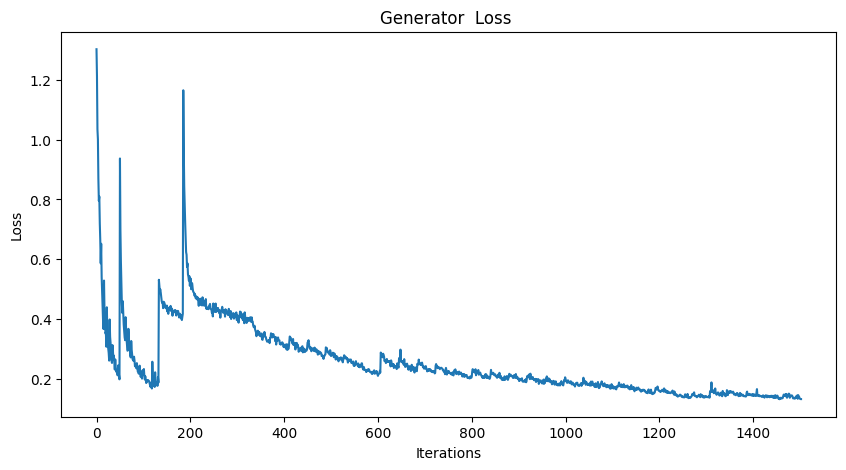

In [20]:
# Plotting the losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(generator_losses)
#plt.plot(discriminator_losses, label='Discriminator Loss')
#plt.plot(multi_scale_losses, label='Multi-Scale Pixel-wise Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Generator  Loss ')
#plt.legend()
plt.show()

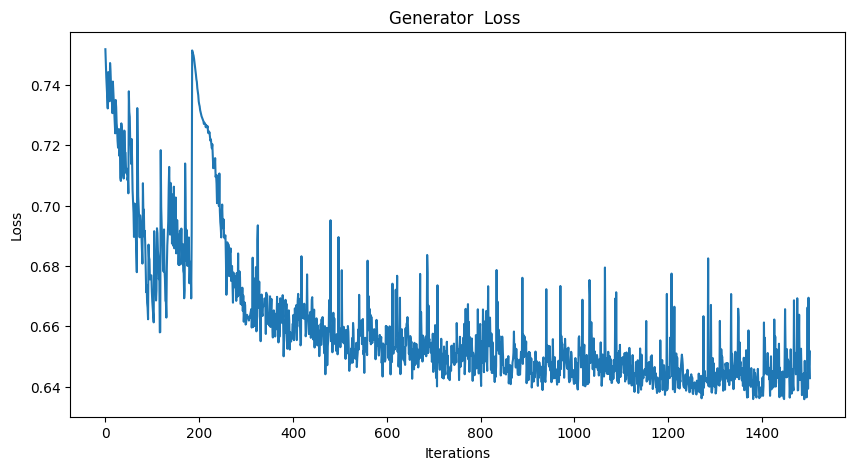

In [21]:
# Plotting the losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
#plt.plot(generator_losses)
plt.plot(discriminator_losses, label='Discriminator Loss')
#plt.plot(multi_scale_losses, label='Multi-Scale Pixel-wise Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Generator  Loss ')
#plt.legend()
plt.show()

In [27]:

for epoch in range(40):  # Assuming 3 epochs for demonstration
    
    # Track loss values for each epoch
    loss_L1 = 0
    loss_L2 = 0
    loss_gan = 0
    total_psnr = 0
    total_ssim = 0
    
   
    with tqdm(total=len(train_pipe_loader), desc=f"Epoch {epoch}") as pbar:
        for i, data in enumerate(train_pipe_loader, 0):
            profile = data[0].view(128, 1, 128, 128).to(device)  # Reshape and move to device
            frontal = data[1].view(128, 1, 128, 128).to(device)  # Reshape and move to device

            # TRAINING THE DISCRIMINATOR
            netD.zero_grad()
            optimizerD.zero_grad()

            real = Variable(frontal).type('torch.FloatTensor').to(device)
            target = Variable(torch.ones(real.size()[0])).to(device)
            profile = Variable(profile).type('torch.FloatTensor').to(device)
            
            real_output = netD(real,real)  # Discriminator output for real images
            generated = netG(profile)  # Generate images from profile
            fake_output = netD(profile, generated.detach())  # Discriminator output for fake images

            # Concatenate real and fake outputs along a new dimension
            concatenated = torch.cat((real_output, fake_output), dim=0)

            # Create labels for real and fake images
            target_real = torch.ones_like(real_output)
            target_fake = torch.zeros_like(fake_output)
            targets = torch.cat((target_real, target_fake), dim=0)

            # Calculate BCE loss for the concatenated outputs
            #errD = F.binary_cross_entropy_with_logits(concatenated, targets)

            errD = criterion(concatenated, targets.float())
            errD.backward()
            optimizerD.step()
             # Accumulate discriminator loss
            discriminator_losses.append(errD.item())

            # TRAINING THE GENERATOR
            netG.zero_grad()
            optimizerG.zero_grad()
            generated = netG(profile)
            output = netD(profile, generated)

            # G wants to have the synthetic images be accepted by D
            errG_GAN = criterion(output, torch.ones_like(output).float())

            # Calculate L1 and L2 loss between generated and real images
            #errG_L1 = F.l1_loss(generated, frontal.float())
            #errG_L2 = F.mse_loss(generated, frontal.float())
            errG_L1 = multi_scale_pixelwise_loss(generated, real)  # Multi-scale pixel-wise loss
           
            #errG_L1 = torch.mean(torch.abs(real - generated))
            errG_L2 = torch.mean(torch.pow((real - generated), 2))
            
            # Total generator loss
            errG = GAN_factor * errG_GAN + L1_factor * errG_L1 + L2_factor * errG_L2
            errG.backward()
            optimizerG.step()

             #Accumulate generator loss
            generator_losses.append(errG.item())

            #Accumulate multi-scale pixel-wise loss
            multi_scale_losses.append(errG_L1.item())

            # Update loss values
            loss_L1 += errG_L1.item()
            loss_L2 += errG_L2.item()
            loss_gan += errG_GAN.item()

            # Calculate PSNR for each generated image and accumulate
            psnr = calculate_psnr(generated, frontal)
            total_psnr += psnr

            # Calculate SSIM for each generated image and accumulate
            ssim_val = calculate_ssim(generated, frontal)
            total_ssim += ssim_val

            pbar.update(1)

   # Append the average losses to the respective lists


    avg_gen_loss = sum(generator_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)
    avg_disc_loss = sum(discriminator_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)
    avg_multi_loss = sum(multi_scale_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)

    avg_generator_losses.append(avg_gen_loss)
    avg_discriminator_losses.append(avg_disc_loss)
    avg_multi_scale_losses.append(avg_multi_loss)
    
    
    # Calculate average PSNR and SSIM for this epoch
    avg_psnr = total_psnr / len(train_pipe_loader)
    avg_ssim = total_ssim / len(train_pipe_loader)

    # Append the average PSNR and SSIM for this epoch to the respective lists
    psnr_values.append(avg_psnr)
    ssim_values.append(avg_ssim)
    
    if epoch == 0:
        print('First training epoch completed in ',(time.time() - start_time),' seconds')
    #if epoch > 0:
        #print(f"Epoch: {epoch} is starting..")
    # reset the DALI iterator
    #train_pipe_loader.reset()

    losses_L1.append(loss_L1 / m_train)
    losses_L2.append(loss_L2 / m_train)
    losses_gan.append(loss_gan / m_train)

     # Save checkpoint after each epoch
    checkpoint_state = {
      'epoch': epoch,
      'netG_state_dict': netG.state_dict(),
      'netD_state_dict': netD.state_dict(),
      'optimizerG_state_dict': optimizerG.state_dict(),
      'optimizerD_state_dict': optimizerD.state_dict(),
      'loss_L1': loss_L1,
      'loss_L2': loss_L2,
      'loss_gan': loss_gan,
      'psnr_values': psnr_values,
      'ssim_values': ssim_values,
      'losses_L1': losses_L1,
      'losses_L2': losses_L2,
      'losses_gan': losses_gan,
      'discriminator_losses': discriminator_losses,
      'generator_losses': generator_losses,
      'multi_scale_losses': multi_scale_losses,
      'avg_generator_losses': avg_generator_losses,
      'avg_discriminator_losses': avg_discriminator_losses,
      'avg_multi_scale_losses': avg_multi_scale_losses,
    }
    torch.save(checkpoint_state, os.path.join(checkpoint_dir1, f"checkpoint_{epoch}.pth"))

    

    # Print the absolute values of three losses to screen:
    print('[%d/40] Training absolute losses: L1 %.7f ; L2 %.7f BCE %.7f; Average PSNR: %.2f; Average SSIM: %.4f' % ((epoch + 1), loss_L1/m_train, loss_L2/m_train, loss_gan/m_train, avg_psnr, avg_ssim, ))

    # Print the PSNR and SSIM on each epoch
    #print('[%d/30] Average PSNR: %.2f, Average SSIM: %.4f' % (epoch + 1, avg_psnr, avg_ssim))

    # Save the inputs, outputs, and ground truth frontals to files:
    vutils.save_image(profile.data, 'FFRAD_CAS_output/%03d_input.jpg' % epoch, normalize=True)
    vutils.save_image(real.data, 'FFRAD_CAS_output/%03d_real.jpg' % epoch, normalize=True)
    vutils.save_image(generated.data, 'FFRAD_CAS_output/%03d_generated.jpg' % epoch, normalize=True)

    

    # Save the pre-trained Generator as well
    torch.save(netG,'FFRAD_CAS_output/netG_%d.pt' % epoch)

Epoch 0: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [3:00:33<00:00, 277.78s/it]


First training epoch completed in  22960.797956466675  seconds
[1/40] Training absolute losses: L1 0.0020342 ; L2 0.0004042 BCE 0.0053799; Average PSNR: 12.86; Average SSIM: 0.5396


Epoch 1:  15%|███████████▍                                                              | 6/39 [05:19<29:17, 53.27s/it]


KeyboardInterrupt: 

In [20]:
latest_epoch = 30
checkpoint_path = os.path.join(checkpoint_dir1, f"checkpoint_{latest_epoch}.pth")
checkpoint = torch.load(checkpoint_path)

# Load model and optimizer states
netG.load_state_dict(checkpoint['netG_state_dict'])
netD.load_state_dict(checkpoint['netD_state_dict'])
optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])

# Load training progress
loss_L1 = checkpoint['loss_L1']
loss_L2 = checkpoint['loss_L2']
loss_gan = checkpoint['loss_gan']
psnr_values = checkpoint['psnr_values']
ssim_values = checkpoint['ssim_values']
losses_L1 = checkpoint['losses_L1']
losses_L2 = checkpoint['losses_L2']
losses_gan = checkpoint['losses_gan']
discriminator_losses = checkpoint['discriminator_losses']
generator_losses = checkpoint['generator_losses']
multi_scale_losses = checkpoint['multi_scale_losses']
avg_generator_losses = checkpoint['avg_generator_losses']
avg_discriminator_losses = checkpoint['avg_discriminator_losses']
avg_multi_scale_losses = checkpoint['avg_multi_scale_losses']

# Start training from the loaded epoch
start_epoch = checkpoint['epoch'] + 1

In [ ]:

for epoch in range(start_epoch,40):  # Assuming 3 epochs for demonstration
    
    # Track loss values for each epoch
    loss_L1 = 0
    loss_L2 = 0
    loss_gan = 0
    total_psnr = 0
    total_ssim = 0
    
   
    with tqdm(total=len(train_pipe_loader), desc=f"Epoch {epoch}") as pbar:
        for i, data in enumerate(train_pipe_loader, 0):
            profile = data[0].view(128, 1, 128, 128).to(device)  # Reshape and move to device
            frontal = data[1].view(128, 1, 128, 128).to(device)  # Reshape and move to device

            # TRAINING THE DISCRIMINATOR
            netD.zero_grad()
            optimizerD.zero_grad()

            real = Variable(frontal).type('torch.FloatTensor').to(device)
            target = Variable(torch.ones(real.size()[0])).to(device)
            profile = Variable(profile).type('torch.FloatTensor').to(device)
            
            real_output = netD(real,real)  # Discriminator output for real images
            generated = netG(profile)  # Generate images from profile
            fake_output = netD(profile, generated.detach())  # Discriminator output for fake images

            # Concatenate real and fake outputs along a new dimension
            concatenated = torch.cat((real_output, fake_output), dim=0)

            # Create labels for real and fake images
            target_real = torch.ones_like(real_output)
            target_fake = torch.zeros_like(fake_output)
            targets = torch.cat((target_real, target_fake), dim=0)

            # Calculate BCE loss for the concatenated outputs
            #errD = F.binary_cross_entropy_with_logits(concatenated, targets)

            errD = criterion(concatenated, targets.float())
            errD.backward()
            optimizerD.step()
             # Accumulate discriminator loss
            discriminator_losses.append(errD.item())

            # TRAINING THE GENERATOR
            netG.zero_grad()
            optimizerG.zero_grad()
            generated = netG(profile)
            output = netD(profile, generated)

            # G wants to have the synthetic images be accepted by D
            errG_GAN = criterion(output, torch.ones_like(output).float())

            # Calculate L1 and L2 loss between generated and real images
            #errG_L1 = F.l1_loss(generated, frontal.float())
            #errG_L2 = F.mse_loss(generated, frontal.float())
            errG_L1 = multi_scale_pixelwise_loss(generated, real)  # Multi-scale pixel-wise loss
           
            #errG_L1 = torch.mean(torch.abs(real - generated))
            errG_L2 = torch.mean(torch.pow((real - generated), 2))
            
            # Total generator loss
            errG = GAN_factor * errG_GAN + L1_factor * errG_L1 + L2_factor * errG_L2
            errG.backward()
            optimizerG.step()

             #Accumulate generator loss
            generator_losses.append(errG.item())

            #Accumulate multi-scale pixel-wise loss
            multi_scale_losses.append(errG_L1.item())

            # Update loss values
            loss_L1 += errG_L1.item()
            loss_L2 += errG_L2.item()
            loss_gan += errG_GAN.item()

            # Calculate PSNR for each generated image and accumulate
            psnr = calculate_psnr(generated, frontal)
            total_psnr += psnr

            # Calculate SSIM for each generated image and accumulate
            ssim_val = calculate_ssim(generated, frontal)
            total_ssim += ssim_val

            pbar.update(1)

   # Append the average losses to the respective lists


    avg_gen_loss = sum(generator_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)
    avg_disc_loss = sum(discriminator_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)
    avg_multi_loss = sum(multi_scale_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)

    avg_generator_losses.append(avg_gen_loss)
    avg_discriminator_losses.append(avg_disc_loss)
    avg_multi_scale_losses.append(avg_multi_loss)
    
    
    # Calculate average PSNR and SSIM for this epoch
    avg_psnr = total_psnr / len(train_pipe_loader)
    avg_ssim = total_ssim / len(train_pipe_loader)

    # Append the average PSNR and SSIM for this epoch to the respective lists
    psnr_values.append(avg_psnr)
    ssim_values.append(avg_ssim)
    
    if epoch == 0:
        print('First training epoch completed in ',(time.time() - start_time),' seconds')
    #if epoch > 0:
        #print(f"Epoch: {epoch} is starting..")
    # reset the DALI iterator
    #train_pipe_loader.reset()

    losses_L1.append(loss_L1 / m_train)
    losses_L2.append(loss_L2 / m_train)
    losses_gan.append(loss_gan / m_train)

     # Save checkpoint after each epoch
    checkpoint_state = {
      'epoch': epoch,
      'netG_state_dict': netG.state_dict(),
      'netD_state_dict': netD.state_dict(),
      'optimizerG_state_dict': optimizerG.state_dict(),
      'optimizerD_state_dict': optimizerD.state_dict(),
      'loss_L1': loss_L1,
      'loss_L2': loss_L2,
      'loss_gan': loss_gan,
      'psnr_values': psnr_values,
      'ssim_values': ssim_values,
      'losses_L1': losses_L1,
      'losses_L2': losses_L2,
      'losses_gan': losses_gan,
      'discriminator_losses': discriminator_losses,
      'generator_losses': generator_losses,
      'multi_scale_losses': multi_scale_losses,
      'avg_generator_losses': avg_generator_losses,
      'avg_discriminator_losses': avg_discriminator_losses,
      'avg_multi_scale_losses': avg_multi_scale_losses,
    }
    torch.save(checkpoint_state, os.path.join(checkpoint_dir1, f"checkpoint_{epoch}.pth"))

    

    # Print the absolute values of three losses to screen:
    print('[%d/40] Training absolute losses: L1 %.7f ; L2 %.7f BCE %.7f; Average PSNR: %.2f; Average SSIM: %.4f' % ((epoch + 1), loss_L1/m_train, loss_L2/m_train, loss_gan/m_train, avg_psnr, avg_ssim, ))

    # Print the PSNR and SSIM on each epoch
    #print('[%d/30] Average PSNR: %.2f, Average SSIM: %.4f' % (epoch + 1, avg_psnr, avg_ssim))

    # Save the inputs, outputs, and ground truth frontals to files:
    vutils.save_image(profile.data, 'FFRAD_CAS_output/%03d_input.jpg' % epoch, normalize=True)
    vutils.save_image(real.data, 'FFRAD_CAS_output/%03d_real.jpg' % epoch, normalize=True)
    vutils.save_image(generated.data, 'FFRAD_CAS_output/%03d_generated.jpg' % epoch, normalize=True)

    

    # Save the pre-trained Generator as well
    torch.save(netG,'FFRAD_CAS_output/netG_%d.pt' % epoch)

Epoch 1: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [3:05:08<00:00, 284.83s/it]


[2/40] Training absolute losses: L1 0.0018189 ; L2 0.0003346 BCE 0.0054548; Average PSNR: 13.70; Average SSIM: 0.6004


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [3:02:53<00:00, 281.36s/it]


[3/40] Training absolute losses: L1 0.0016262 ; L2 0.0002760 BCE 0.0054760; Average PSNR: 14.54; Average SSIM: 0.6548


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [3:03:00<00:00, 281.56s/it]


[4/40] Training absolute losses: L1 0.0014816 ; L2 0.0002378 BCE 0.0054776; Average PSNR: 15.20; Average SSIM: 0.6943


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [3:02:23<00:00, 280.59s/it]


[5/40] Training absolute losses: L1 0.0013631 ; L2 0.0002037 BCE 0.0054893; Average PSNR: 15.86; Average SSIM: 0.7215


Epoch 5: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [3:10:37<00:00, 293.27s/it]


[6/40] Training absolute losses: L1 0.0012299 ; L2 0.0001699 BCE 0.0054461; Average PSNR: 16.64; Average SSIM: 0.7574


Epoch 6: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [3:03:23<00:00, 282.14s/it]


[7/40] Training absolute losses: L1 0.0010896 ; L2 0.0001361 BCE 0.0054975; Average PSNR: 17.59; Average SSIM: 0.7940


Epoch 7: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [3:02:40<00:00, 281.03s/it]


[8/40] Training absolute losses: L1 0.0010124 ; L2 0.0001186 BCE 0.0054976; Average PSNR: 18.17; Average SSIM: 0.8148


Epoch 8: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [3:01:49<00:00, 279.73s/it]


[9/40] Training absolute losses: L1 0.0009526 ; L2 0.0001064 BCE 0.0055020; Average PSNR: 18.64; Average SSIM: 0.8268


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████| 39/39 [3:02:27<00:00, 280.70s/it]


[10/40] Training absolute losses: L1 0.0008863 ; L2 0.0000921 BCE 0.0054772; Average PSNR: 19.26; Average SSIM: 0.8449


Epoch 10: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [3:03:08<00:00, 281.77s/it]


[11/40] Training absolute losses: L1 0.0008239 ; L2 0.0000811 BCE 0.0054883; Average PSNR: 19.80; Average SSIM: 0.8583


Epoch 11: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [3:04:45<00:00, 284.26s/it]


[12/40] Training absolute losses: L1 0.0008160 ; L2 0.0000767 BCE 0.0054678; Average PSNR: 20.05; Average SSIM: 0.8637


Epoch 12: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [3:02:38<00:00, 280.99s/it]


[13/40] Training absolute losses: L1 0.0007457 ; L2 0.0000674 BCE 0.0054781; Average PSNR: 20.60; Average SSIM: 0.8773


Epoch 13: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [3:02:54<00:00, 281.39s/it]


[14/40] Training absolute losses: L1 0.0007256 ; L2 0.0000628 BCE 0.0054408; Average PSNR: 20.91; Average SSIM: 0.8848


Epoch 14: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [3:04:18<00:00, 283.56s/it]


[15/40] Training absolute losses: L1 0.0006965 ; L2 0.0000588 BCE 0.0054612; Average PSNR: 21.20; Average SSIM: 0.8912


Epoch 15: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [3:05:01<00:00, 284.65s/it]


[16/40] Training absolute losses: L1 0.0006679 ; L2 0.0000545 BCE 0.0054738; Average PSNR: 21.53; Average SSIM: 0.8965


Epoch 16: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [3:05:00<00:00, 284.63s/it]


[17/40] Training absolute losses: L1 0.0006360 ; L2 0.0000504 BCE 0.0054934; Average PSNR: 21.86; Average SSIM: 0.9049


Epoch 17: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [3:03:47<00:00, 282.75s/it]


[18/40] Training absolute losses: L1 0.0006163 ; L2 0.0000478 BCE 0.0054474; Average PSNR: 22.09; Average SSIM: 0.9094


Epoch 18: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [3:05:27<00:00, 285.33s/it]


[19/40] Training absolute losses: L1 0.0006136 ; L2 0.0000457 BCE 0.0054640; Average PSNR: 22.28; Average SSIM: 0.9105


Epoch 19: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [3:02:47<00:00, 281.22s/it]


[20/40] Training absolute losses: L1 0.0005905 ; L2 0.0000434 BCE 0.0054839; Average PSNR: 22.51; Average SSIM: 0.9138


Epoch 20: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [3:02:24<00:00, 280.62s/it]


[21/40] Training absolute losses: L1 0.0005710 ; L2 0.0000414 BCE 0.0053709; Average PSNR: 22.71; Average SSIM: 0.9200


Epoch 21: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [3:03:47<00:00, 282.76s/it]


[22/40] Training absolute losses: L1 0.0005433 ; L2 0.0000380 BCE 0.0053739; Average PSNR: 23.08; Average SSIM: 0.9257


Epoch 22: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [3:03:33<00:00, 282.39s/it]


[23/40] Training absolute losses: L1 0.0005435 ; L2 0.0000376 BCE 0.0054659; Average PSNR: 23.13; Average SSIM: 0.9254


Epoch 23: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [3:04:18<00:00, 283.55s/it]


[24/40] Training absolute losses: L1 0.0005201 ; L2 0.0000352 BCE 0.0054957; Average PSNR: 23.42; Average SSIM: 0.9319


Epoch 24: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [3:06:32<00:00, 286.98s/it]


[25/40] Training absolute losses: L1 0.0005299 ; L2 0.0000350 BCE 0.0054711; Average PSNR: 23.44; Average SSIM: 0.9294


Epoch 25: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [3:05:42<00:00, 285.69s/it]


[26/40] Training absolute losses: L1 0.0005185 ; L2 0.0000336 BCE 0.0054927; Average PSNR: 23.63; Average SSIM: 0.9310


Epoch 26: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [3:09:27<00:00, 291.49s/it]


[27/40] Training absolute losses: L1 0.0004947 ; L2 0.0000320 BCE 0.0054790; Average PSNR: 23.83; Average SSIM: 0.9367


Epoch 27: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [3:03:35<00:00, 282.45s/it]


[28/40] Training absolute losses: L1 0.0004926 ; L2 0.0000310 BCE 0.0054926; Average PSNR: 23.97; Average SSIM: 0.9375


Epoch 28: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [3:10:45<00:00, 293.47s/it]


[29/40] Training absolute losses: L1 0.0004931 ; L2 0.0000310 BCE 0.0054941; Average PSNR: 23.98; Average SSIM: 0.9383


Epoch 29: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [3:24:25<00:00, 314.51s/it]


[30/40] Training absolute losses: L1 0.0004695 ; L2 0.0000289 BCE 0.0053932; Average PSNR: 24.27; Average SSIM: 0.9435


Epoch 30: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [3:04:32<00:00, 283.91s/it]


[31/40] Training absolute losses: L1 0.0004548 ; L2 0.0000274 BCE 0.0054837; Average PSNR: 24.50; Average SSIM: 0.9428


Epoch 31:  69%|██████████████████████████████████████████████▍                    | 27/39 [1:30:57<1:09:04, 345.36s/it]

In [ ]:

for epoch in range(start_epoch,40):  # Assuming 3 epochs for demonstration
    
    # Track loss values for each epoch
    loss_L1 = 0
    loss_L2 = 0
    loss_gan = 0
    total_psnr = 0
    total_ssim = 0
    
   
    with tqdm(total=len(train_pipe_loader), desc=f"Epoch {epoch}") as pbar:
        for i, data in enumerate(train_pipe_loader, 0):
            profile = data[0].view(128, 1, 128, 128).to(device)  # Reshape and move to device
            frontal = data[1].view(128, 1, 128, 128).to(device)  # Reshape and move to device

            # TRAINING THE DISCRIMINATOR
            netD.zero_grad()
            optimizerD.zero_grad()

            real = Variable(frontal).type('torch.FloatTensor').to(device)
            target = Variable(torch.ones(real.size()[0])).to(device)
            profile = Variable(profile).type('torch.FloatTensor').to(device)
            
            real_output = netD(real,real)  # Discriminator output for real images
            generated = netG(profile)  # Generate images from profile
            fake_output = netD(profile, generated.detach())  # Discriminator output for fake images

            # Concatenate real and fake outputs along a new dimension
            concatenated = torch.cat((real_output, fake_output), dim=0)

            # Create labels for real and fake images
            target_real = torch.ones_like(real_output)
            target_fake = torch.zeros_like(fake_output)
            targets = torch.cat((target_real, target_fake), dim=0)

            # Calculate BCE loss for the concatenated outputs
            #errD = F.binary_cross_entropy_with_logits(concatenated, targets)

            errD = criterion(concatenated, targets.float())
            errD.backward()
            optimizerD.step()
             # Accumulate discriminator loss
            discriminator_losses.append(errD.item())

            # TRAINING THE GENERATOR
            netG.zero_grad()
            optimizerG.zero_grad()
            generated = netG(profile)
            output = netD(profile, generated)

            # G wants to have the synthetic images be accepted by D
            errG_GAN = criterion(output, torch.ones_like(output).float())

            # Calculate L1 and L2 loss between generated and real images
            #errG_L1 = F.l1_loss(generated, frontal.float())
            #errG_L2 = F.mse_loss(generated, frontal.float())
            errG_L1 = multi_scale_pixelwise_loss(generated, real)  # Multi-scale pixel-wise loss
           
            #errG_L1 = torch.mean(torch.abs(real - generated))
            errG_L2 = torch.mean(torch.pow((real - generated), 2))
            
            # Total generator loss
            errG = GAN_factor * errG_GAN + L1_factor * errG_L1 + L2_factor * errG_L2
            errG.backward()
            optimizerG.step()

             #Accumulate generator loss
            generator_losses.append(errG.item())

            #Accumulate multi-scale pixel-wise loss
            multi_scale_losses.append(errG_L1.item())

            # Update loss values
            loss_L1 += errG_L1.item()
            loss_L2 += errG_L2.item()
            loss_gan += errG_GAN.item()

            # Calculate PSNR for each generated image and accumulate
            psnr = calculate_psnr(generated, frontal)
            total_psnr += psnr

            # Calculate SSIM for each generated image and accumulate
            ssim_val = calculate_ssim(generated, frontal)
            total_ssim += ssim_val

            pbar.update(1)

   # Append the average losses to the respective lists


    avg_gen_loss = sum(generator_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)
    avg_disc_loss = sum(discriminator_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)
    avg_multi_loss = sum(multi_scale_losses[epoch * len(train_pipe_loader):(epoch + 1) * len(train_pipe_loader)]) / len(train_pipe_loader)

    avg_generator_losses.append(avg_gen_loss)
    avg_discriminator_losses.append(avg_disc_loss)
    avg_multi_scale_losses.append(avg_multi_loss)
    
    
    # Calculate average PSNR and SSIM for this epoch
    avg_psnr = total_psnr / len(train_pipe_loader)
    avg_ssim = total_ssim / len(train_pipe_loader)

    # Append the average PSNR and SSIM for this epoch to the respective lists
    psnr_values.append(avg_psnr)
    ssim_values.append(avg_ssim)
    
    if epoch == 0:
        print('First training epoch completed in ',(time.time() - start_time),' seconds')
    #if epoch > 0:
        #print(f"Epoch: {epoch} is starting..")
    # reset the DALI iterator
    #train_pipe_loader.reset()

    losses_L1.append(loss_L1 / m_train)
    losses_L2.append(loss_L2 / m_train)
    losses_gan.append(loss_gan / m_train)

     # Save checkpoint after each epoch
    checkpoint_state = {
      'epoch': epoch,
      'netG_state_dict': netG.state_dict(),
      'netD_state_dict': netD.state_dict(),
      'optimizerG_state_dict': optimizerG.state_dict(),
      'optimizerD_state_dict': optimizerD.state_dict(),
      'loss_L1': loss_L1,
      'loss_L2': loss_L2,
      'loss_gan': loss_gan,
      'psnr_values': psnr_values,
      'ssim_values': ssim_values,
      'losses_L1': losses_L1,
      'losses_L2': losses_L2,
      'losses_gan': losses_gan,
      'discriminator_losses': discriminator_losses,
      'generator_losses': generator_losses,
      'multi_scale_losses': multi_scale_losses,
      'avg_generator_losses': avg_generator_losses,
      'avg_discriminator_losses': avg_discriminator_losses,
      'avg_multi_scale_losses': avg_multi_scale_losses,
    }
    torch.save(checkpoint_state, os.path.join(checkpoint_dir1, f"checkpoint_{epoch}.pth"))

    

    # Print the absolute values of three losses to screen:
    print('[%d/40] Training absolute losses: L1 %.7f ; L2 %.7f BCE %.7f; Average PSNR: %.2f; Average SSIM: %.4f' % ((epoch + 1), loss_L1/m_train, loss_L2/m_train, loss_gan/m_train, avg_psnr, avg_ssim, ))

    # Print the PSNR and SSIM on each epoch
    #print('[%d/30] Average PSNR: %.2f, Average SSIM: %.4f' % (epoch + 1, avg_psnr, avg_ssim))

    # Save the inputs, outputs, and ground truth frontals to files:
    vutils.save_image(profile.data, 'FFRAD_CAS_output/%03d_input.jpg' % epoch, normalize=True)
    vutils.save_image(real.data, 'FFRAD_CAS_output/%03d_real.jpg' % epoch, normalize=True)
    vutils.save_image(generated.data, 'FFRAD_CAS_output/%03d_generated.jpg' % epoch, normalize=True)

    

    # Save the pre-trained Generator as well
    torch.save(netG,'FFRAD_CAS_output/netG_%d.pt' % epoch)

Epoch 31: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [2:54:27<00:00, 268.39s/it]


[32/40] Training absolute losses: L1 0.0005859 ; L2 0.0000458 BCE 0.0054510; Average PSNR: 22.50; Average SSIM: 0.9208


Epoch 32: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [2:51:26<00:00, 263.76s/it]


[33/40] Training absolute losses: L1 0.0005185 ; L2 0.0000353 BCE 0.0054886; Average PSNR: 23.50; Average SSIM: 0.9357


Epoch 33: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [3:25:00<00:00, 315.39s/it]


[34/40] Training absolute losses: L1 0.0005383 ; L2 0.0000375 BCE 0.0054895; Average PSNR: 23.29; Average SSIM: 0.9318


Epoch 34: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [2:52:37<00:00, 265.57s/it]


[35/40] Training absolute losses: L1 0.0004855 ; L2 0.0000322 BCE 0.0054034; Average PSNR: 23.88; Average SSIM: 0.9415


Epoch 35: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [2:52:48<00:00, 265.86s/it]


[36/40] Training absolute losses: L1 0.0004716 ; L2 0.0000295 BCE 0.0054798; Average PSNR: 24.24; Average SSIM: 0.9455


Epoch 36: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [2:52:41<00:00, 265.67s/it]


[37/40] Training absolute losses: L1 0.0004349 ; L2 0.0000252 BCE 0.0054435; Average PSNR: 24.87; Average SSIM: 0.9504


Epoch 37: 100%|█████████████████████████████████████████████████████████████████████| 39/39 [2:50:34<00:00, 262.42s/it]


[38/40] Training absolute losses: L1 0.0004374 ; L2 0.0000248 BCE 0.0054806; Average PSNR: 24.94; Average SSIM: 0.9501


Epoch 38:  56%|██████████████████████████████████████▉                              | 22/39 [54:44<1:13:44, 260.27s/it]